# Part 1: Data Collection and Processing

In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 18.6 MB/s eta 0:00:00


In [ ]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import arch
from scipy import stats
import warnings
import scipy.optimize as sco
from scipy.stats import norm


%matplotlib inline

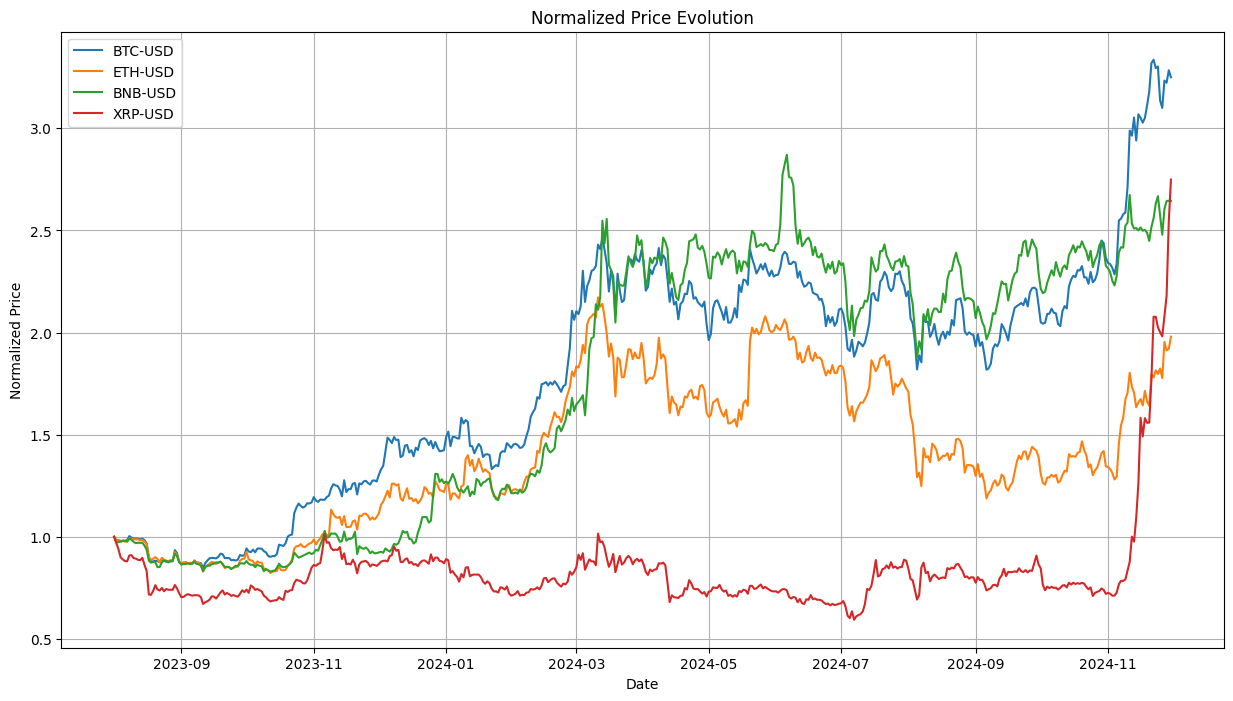


Basic Statistics of Daily Returns:
          BTC-USD     ETH-USD     BNB-USD     XRP-USD
count  487.000000  487.000000  487.000000  487.000000
mean     0.002766    0.001879    0.002379    0.002747
std      0.026346    0.031130    0.027804    0.037235
min     -0.083434   -0.102436   -0.107038   -0.137994
25%     -0.010110   -0.013298   -0.011062   -0.013625
50%      0.000724    0.000956    0.001322    0.000321
75%      0.014995    0.016123    0.015015    0.015104
max      0.121443    0.192722    0.172340    0.254457

there is no missing data


In [ ]:

np.random.seed(42)


def fetch_crypto_data(symbols, start_date, end_date):
    data = {}
    for symbol in symbols:
        ticker = yf.Ticker(symbol)
        df = ticker.history(start=start_date, end=end_date)
        data[symbol] = df
    return data


symbols = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD']
start_date = '2023-08-01'
end_date = '2024-12-01'
split_date = '2024-08-01'


crypto_data = fetch_crypto_data(symbols, start_date, end_date)


def create_price_df(data):
    df = pd.DataFrame()
    for symbol in symbols:
        df[symbol] = data[symbol]['Close']
    return df

price_df = create_price_df(crypto_data)


train_df = price_df[price_df.index < split_date]
test_df = price_df[price_df.index >= split_date]


returns_df = price_df.pct_change().dropna()


plt.figure(figsize=(15, 8))
for symbol in symbols:
    plt.plot(price_df.index, price_df[symbol]/price_df[symbol].iloc[0], label=symbol)
plt.title('Normalized Price Evolution')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()


print("\nBasic Statistics of Daily Returns:")
print(returns_df.describe())


missing_data = price_df.isnull().sum()
print()
if (not missing_data.any()):
    print("there is no missing data")
else:
    print("\nMissing Values:")
    print(missing_data)

## Explanation
This code will:
1. Import required libraries
2. Fetch historical data for the specified cryptocurrencies
3. Create price and returns DataFrames
4. Split the data into training and test sets
5. Perform basic data visualization and statistics

# Part 2: Volatility Prediction

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/

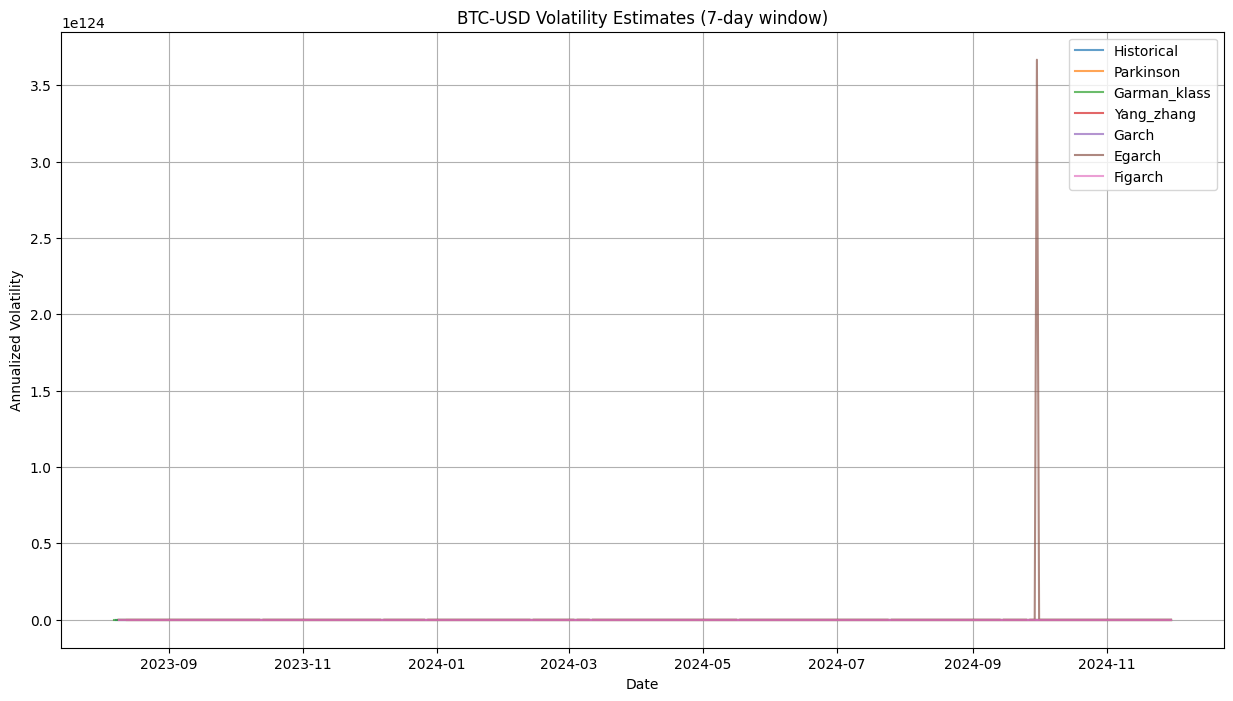

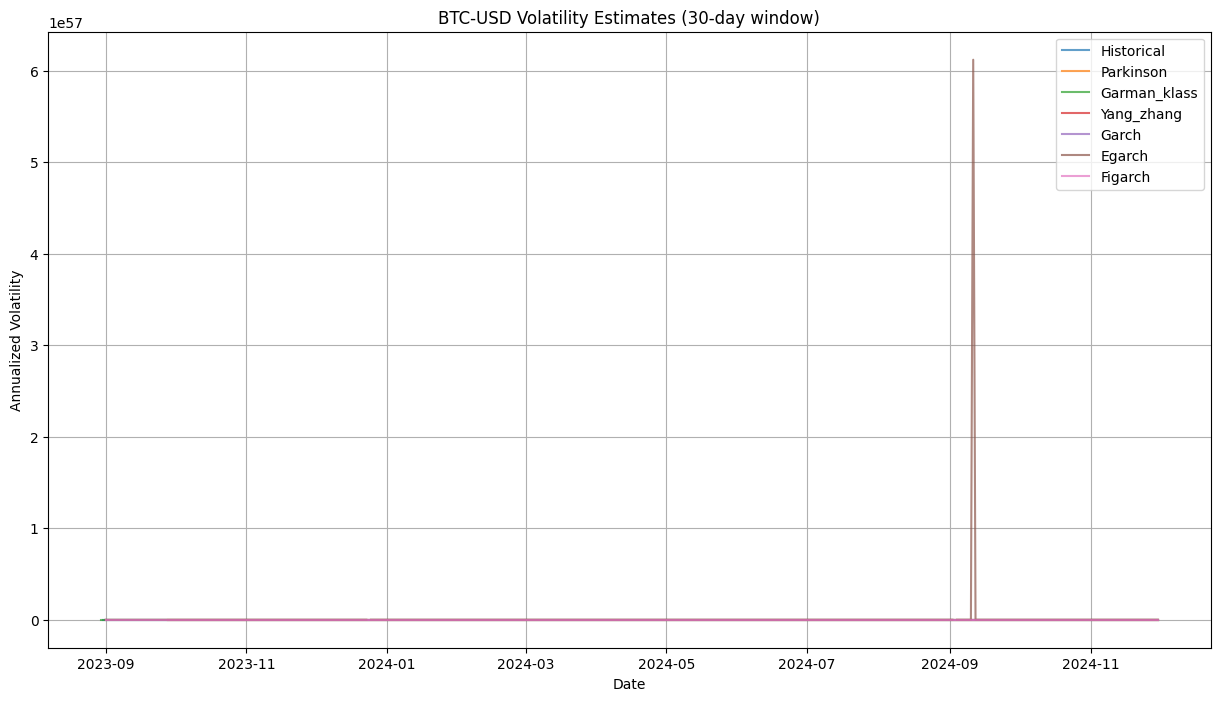

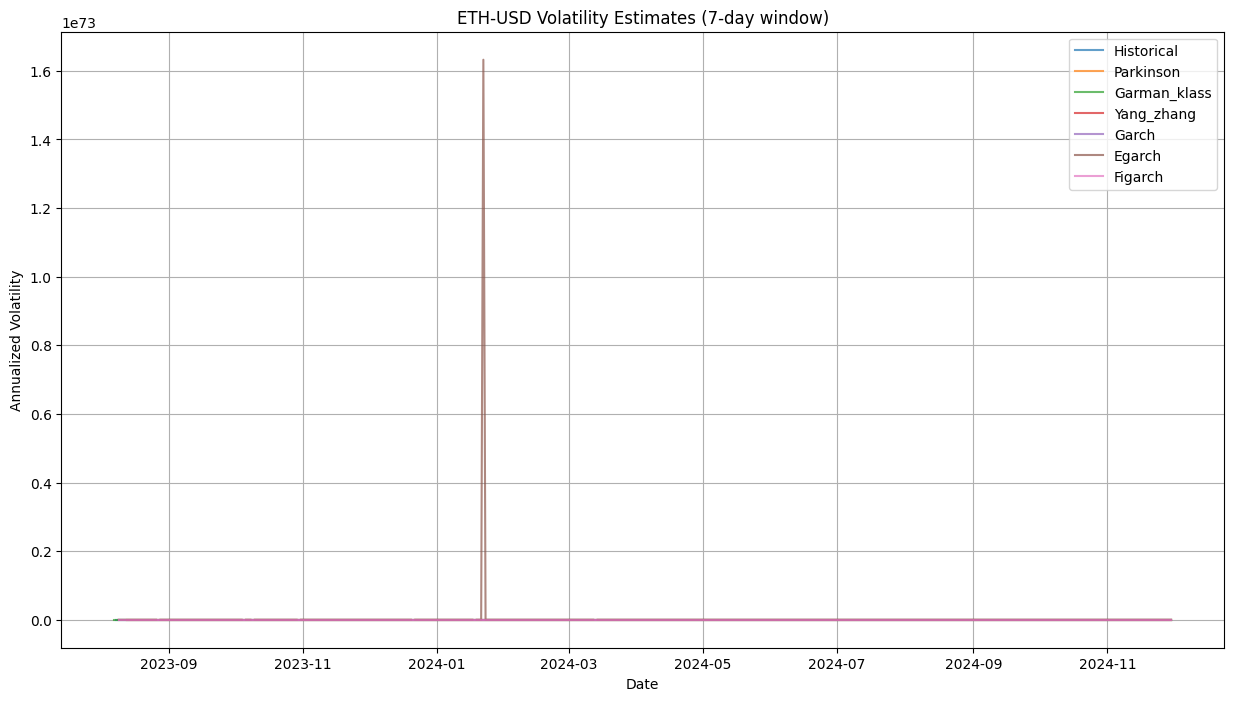

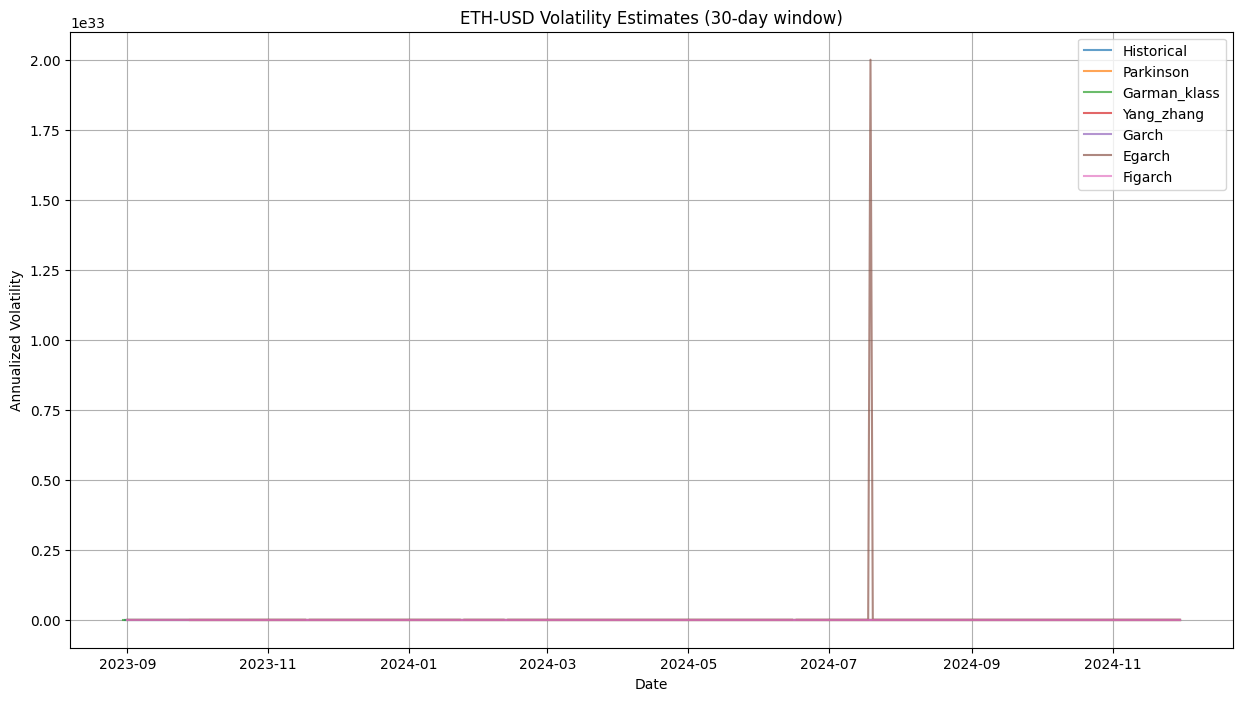

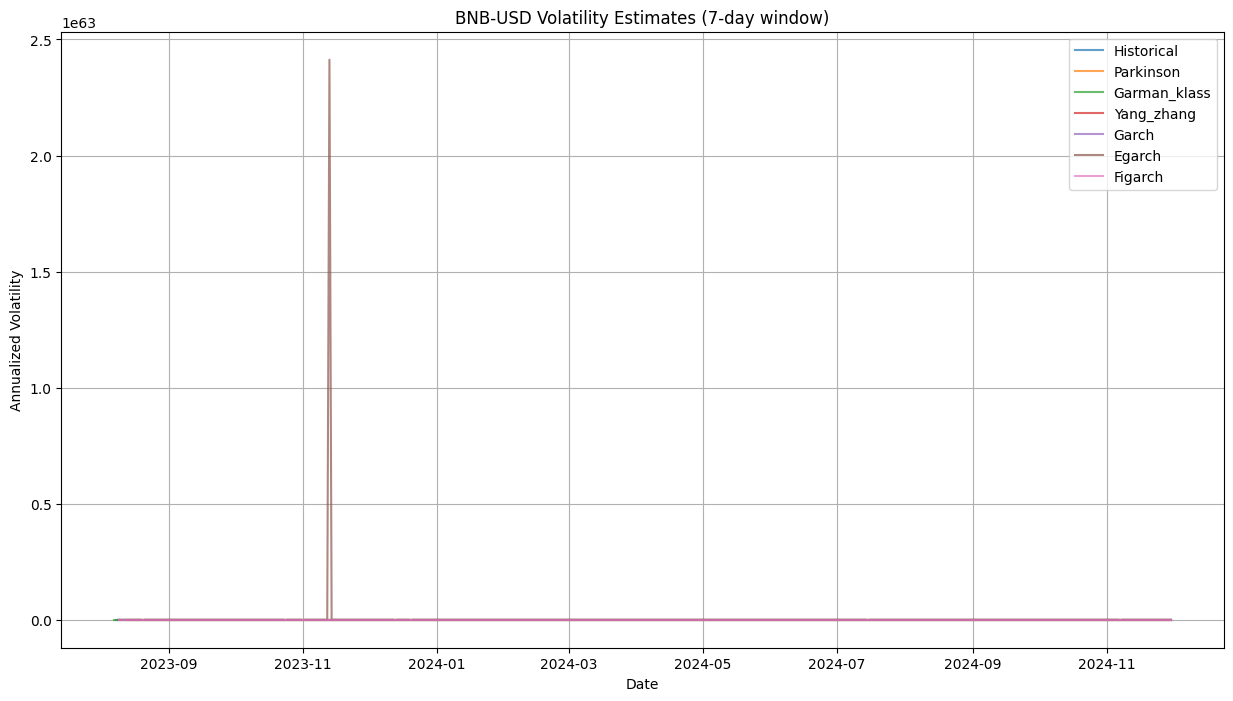

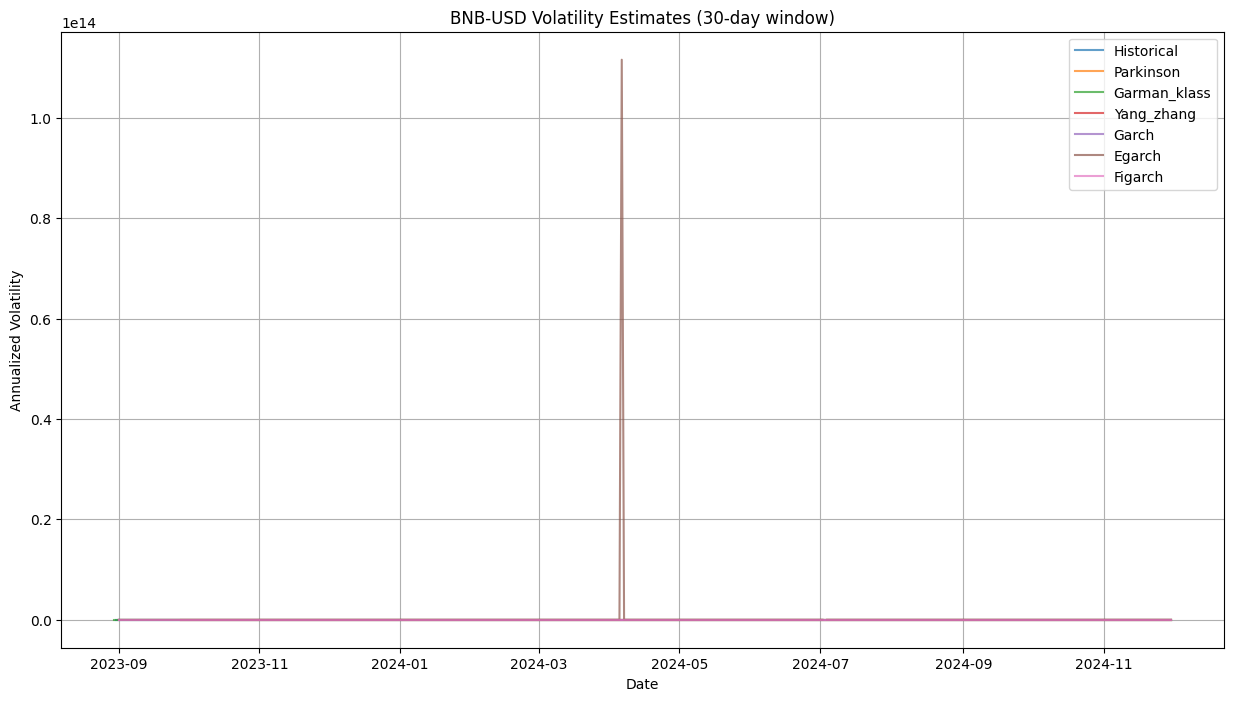

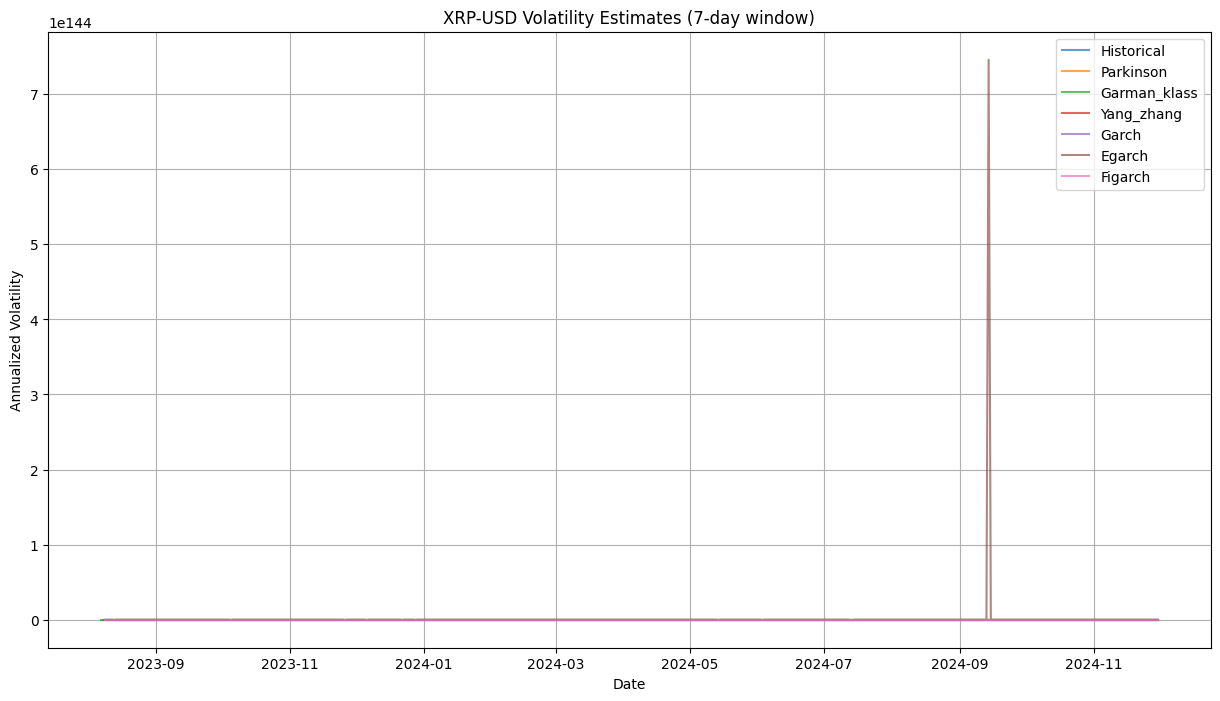

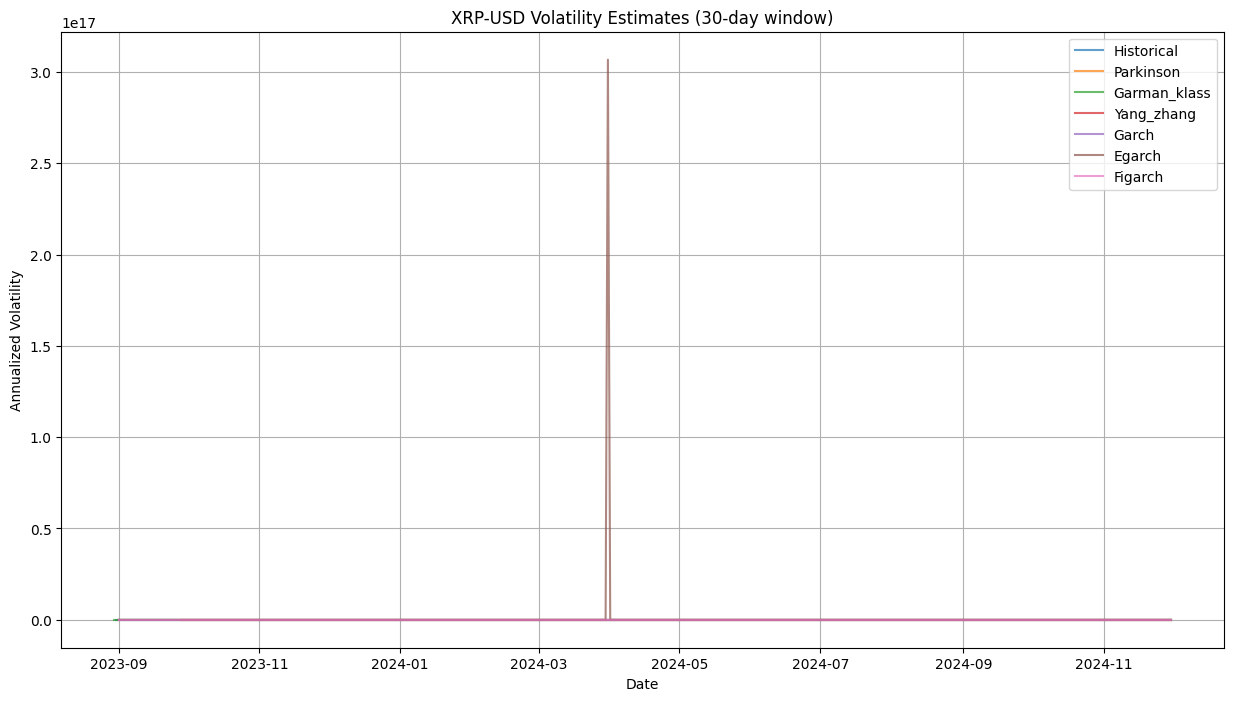


Correlation Analysis for BTC-USD (7-day window):


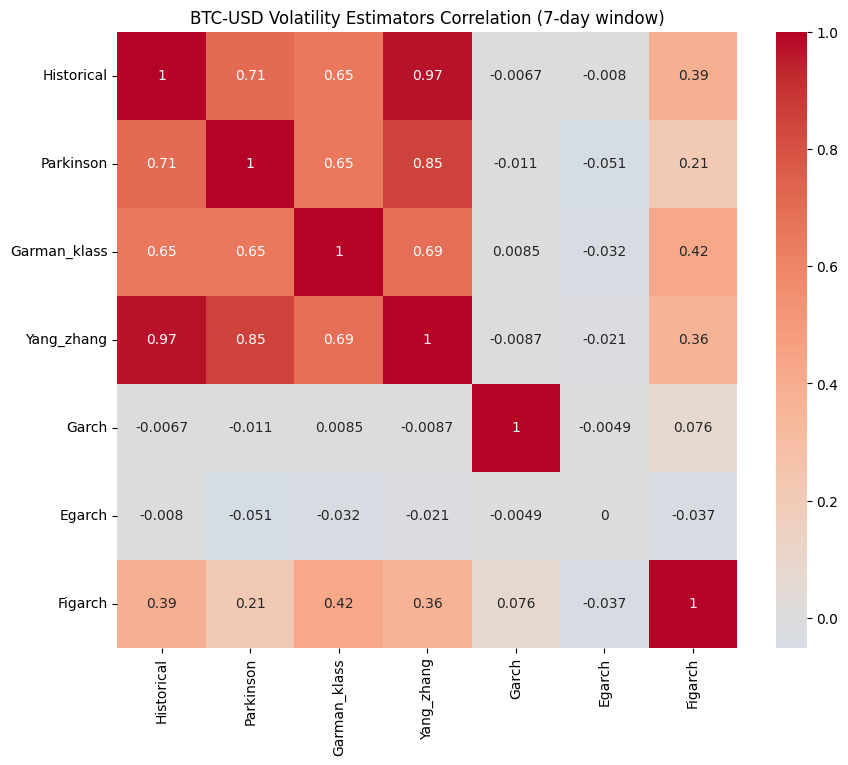


Correlation Analysis for BTC-USD (30-day window):


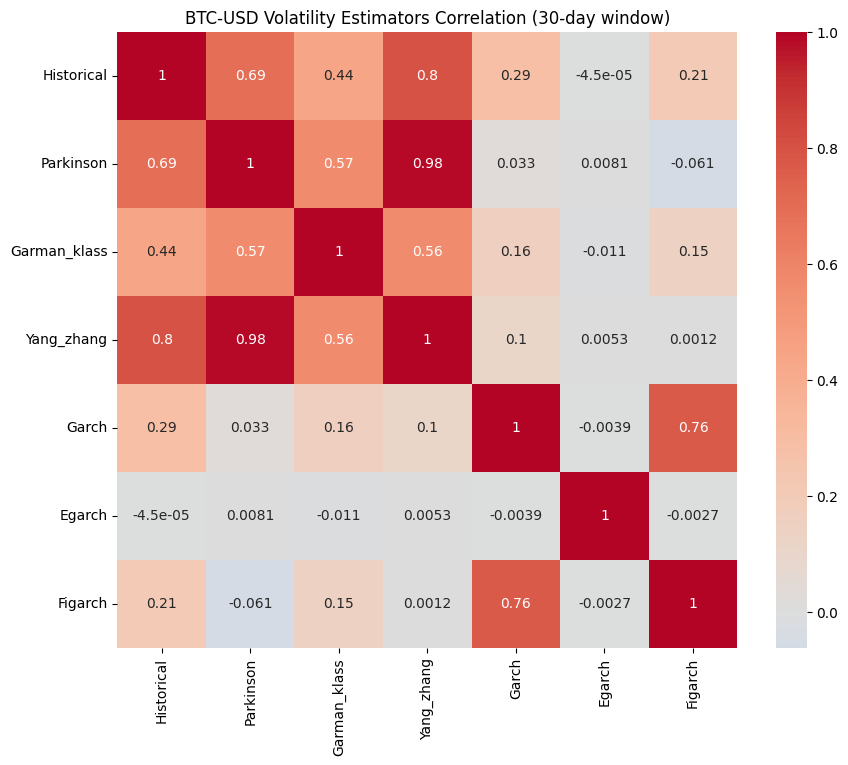


Correlation Analysis for ETH-USD (7-day window):


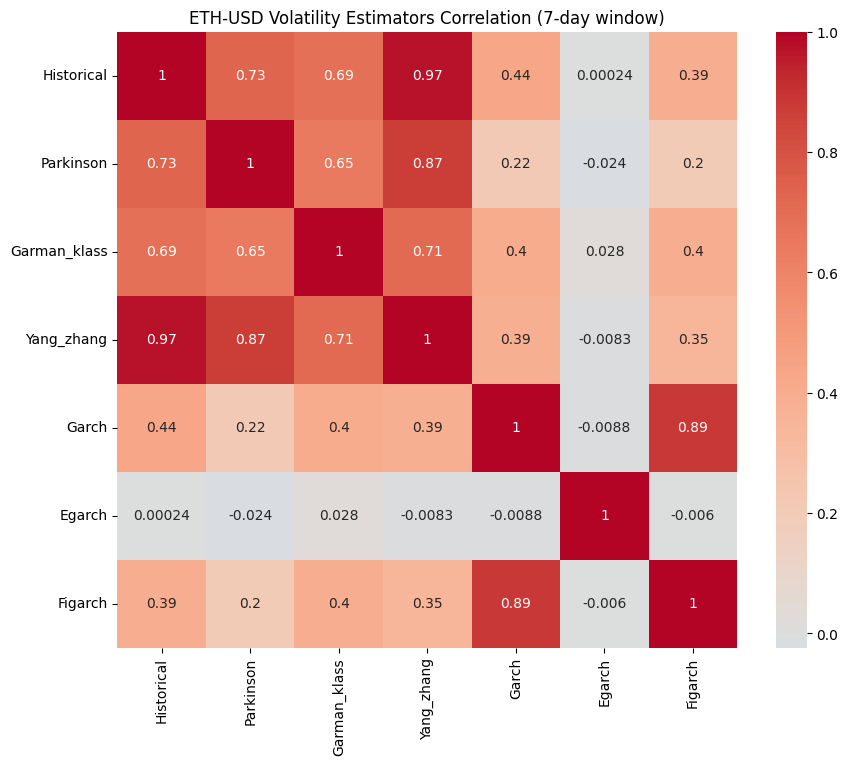


Correlation Analysis for ETH-USD (30-day window):


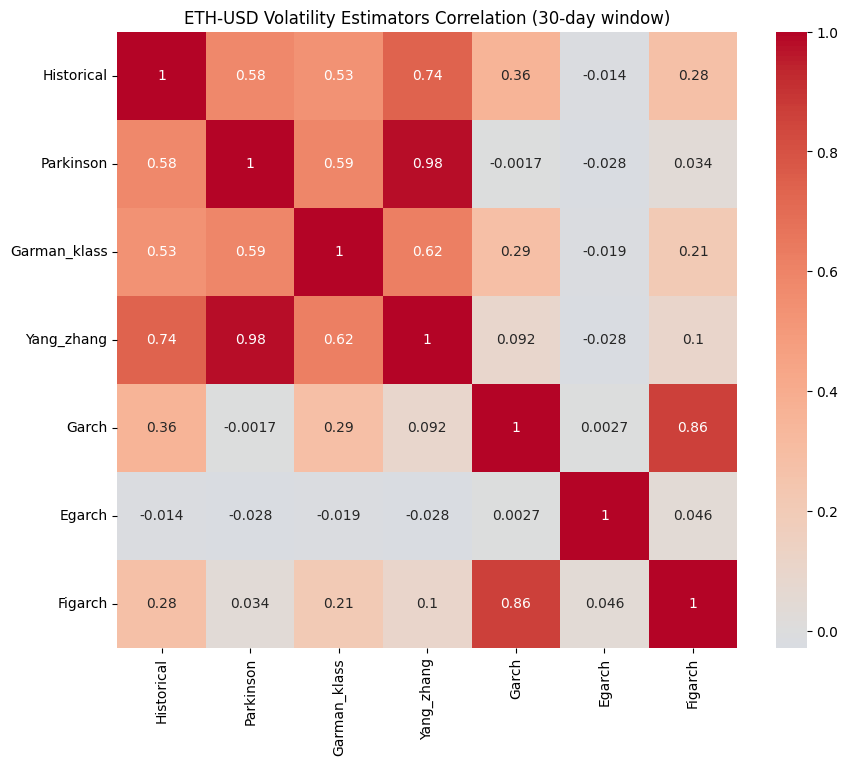


Correlation Analysis for BNB-USD (7-day window):


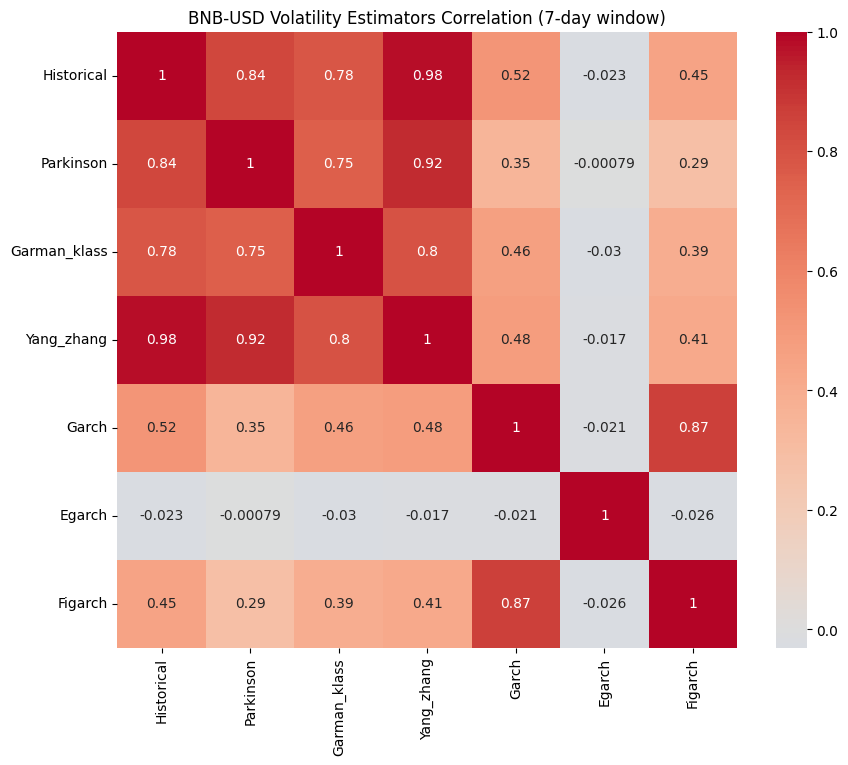


Correlation Analysis for BNB-USD (30-day window):


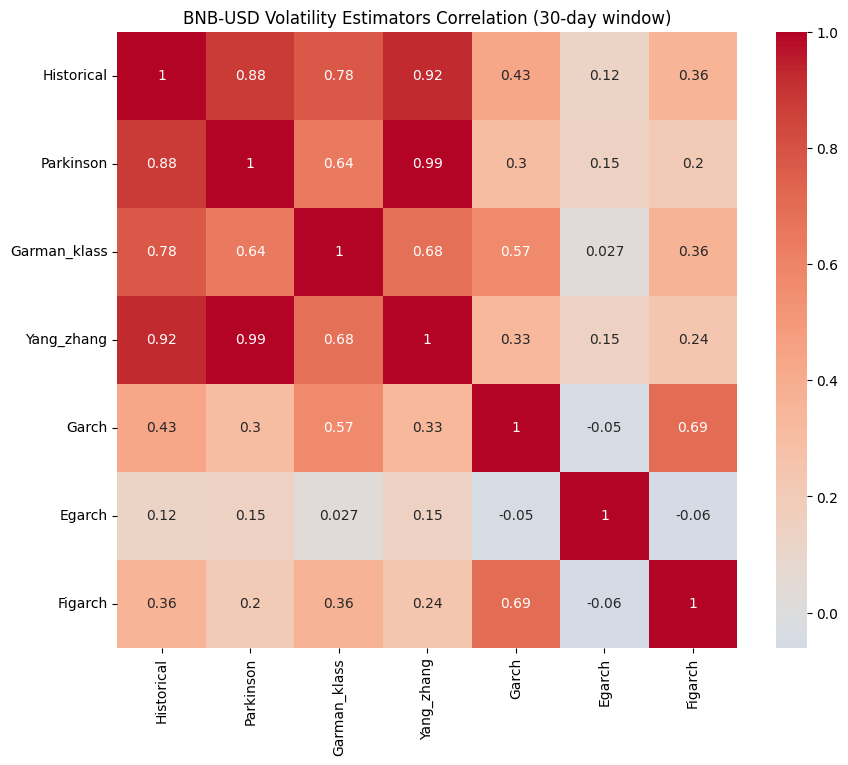


Correlation Analysis for XRP-USD (7-day window):


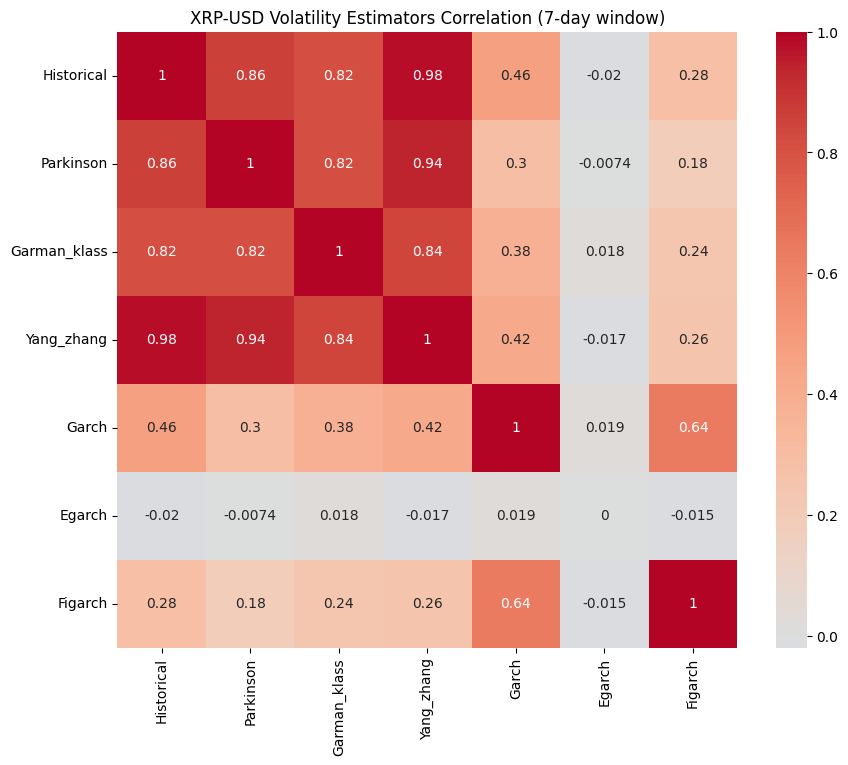


Correlation Analysis for XRP-USD (30-day window):


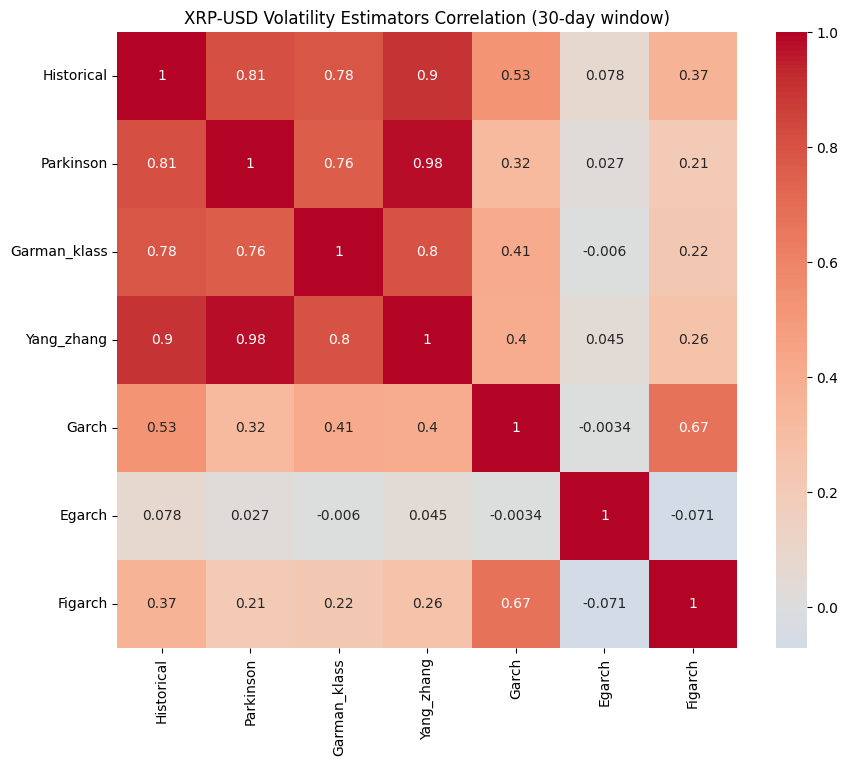

In [ ]:


import arch
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class VolatilityEstimator:
    def __init__(self, prices_df):
        self.prices = prices_df
        self.returns = prices_df.pct_change().dropna()

    def calculate_historical_volatility(self, window):
        """Calculate historical volatility"""
        return self.returns.rolling(window=window).std() * np.sqrt(252)

    def calculate_parkinson_volatility(self, window):
        """Calculate Parkinson volatility using high-low range"""
        high = pd.DataFrame()
        low = pd.DataFrame()

        for symbol in self.prices.columns:
            high[symbol] = self.prices[symbol].rolling(window).max()
            low[symbol] = self.prices[symbol].rolling(window).min()

        k = 1 / (4 * np.log(2))
        return np.sqrt(k * (np.log(high/low)**2).rolling(window).mean() * 252)

    def calculate_garman_klass_volatility(self, window):
        """Calculate Garman-Klass volatility"""
        log_hl = (self.prices.rolling(window).max() /
                 self.prices.rolling(window).min()).apply(np.log)

        return np.sqrt(0.5 * log_hl**2 * 252)

    def calculate_yang_zhang_volatility(self, window):
        """Calculate Yang-Zhang volatility"""
        returns = self.returns

        
        open_close = returns.rolling(window).std() * np.sqrt(252)

        
        high_low = self.calculate_parkinson_volatility(window)

        
        k = 0.34 / (1.34 + (window + 1) / (window - 1))
        return np.sqrt(open_close**2 + k * high_low**2)

    def calculate_garch_volatility(self, window):
        """Calculate GARCH(1,1) volatility"""
        volatility = pd.DataFrame()

        for symbol in self.returns.columns:
            returns_series = self.returns[symbol].dropna()
            model = arch.arch_model(returns_series, vol='Garch', p=1, q=1)

            
            forecasts = []
            for i in range(len(returns_series) - window):
                end_loc = i + window
                res = model.fit(first_obs=i, last_obs=end_loc, disp='off')
                forecast = res.forecast().variance.values[-1]
                forecasts.append(np.sqrt(forecast * 252))

            volatility[symbol] = pd.Series(forecasts, index=returns_series.index[window:])

        return volatility

    def calculate_egarch_volatility(self, window):
        """Calculate EGARCH(1,1) volatility"""
        volatility = pd.DataFrame()

        for symbol in self.returns.columns:
            returns_series = self.returns[symbol].dropna()
            model = arch.arch_model(returns_series, vol='EGARCH', p=1, q=1)

            
            forecasts = []
            for i in range(len(returns_series) - window):
                end_loc = i + window
                res = model.fit(first_obs=i, last_obs=end_loc, disp='off')
                forecast = res.forecast().variance.values[-1]
                forecasts.append(np.sqrt(forecast * 252))

            volatility[symbol] = pd.Series(forecasts, index=returns_series.index[window:])

        return volatility

    def calculate_figarch_volatility(self, window):
        """Calculate FIGARCH volatility"""
        volatility = pd.DataFrame()

        for symbol in self.returns.columns:
            returns_series = self.returns[symbol].dropna()
            
            model = arch.arch_model(returns_series, vol='Garch', p=2, q=2)

            
            forecasts = []
            for i in range(len(returns_series) - window):
                end_loc = i + window
                res = model.fit(first_obs=i, last_obs=end_loc, disp='off')
                forecast = res.forecast().variance.values[-1]
                forecasts.append(np.sqrt(forecast * 252))

            volatility[symbol] = pd.Series(forecasts, index=returns_series.index[window:])

        return volatility

def calculate_all_volatilities(prices_df, windows=[7, 30]):
    """Calculate all volatility measures for given windows"""
    vol_estimator = VolatilityEstimator(prices_df)
    volatility_results = {}

    for window in windows:
        volatility_results[f'window_{window}'] = {
            'historical': vol_estimator.calculate_historical_volatility(window),
            'parkinson': vol_estimator.calculate_parkinson_volatility(window),
            'garman_klass': vol_estimator.calculate_garman_klass_volatility(window),
            'yang_zhang': vol_estimator.calculate_yang_zhang_volatility(window),
            'garch': vol_estimator.calculate_garch_volatility(window),
            'egarch': vol_estimator.calculate_egarch_volatility(window),
            'figarch': vol_estimator.calculate_figarch_volatility(window)
        }

    return volatility_results


volatility_results = calculate_all_volatilities(price_df)


def plot_volatility_comparison(volatility_results, symbol, window):
    """Plot comparison of different volatility measures for a given symbol"""
    plt.figure(figsize=(15, 8))

    methods = ['historical', 'parkinson', 'garman_klass', 'yang_zhang',
              'garch', 'egarch', 'figarch']

    for method in methods:
        vol = volatility_results[f'window_{window}'][method][symbol]
        plt.plot(vol.index, vol, label=method.capitalize(), alpha=0.7)

    plt.title(f'{symbol} Volatility Estimates ({window}-day window)')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()


for symbol in price_df.columns:
    for window in [7, 30]:
        plot_volatility_comparison(volatility_results, symbol, window)


def analyze_volatility_correlations(volatility_results, symbol, window):
    """Analyze correlations between different volatility measures"""
    methods = ['historical', 'parkinson', 'garman_klass', 'yang_zhang',
              'garch', 'egarch', 'figarch']

    vol_data = pd.DataFrame()
    for method in methods:
        vol_data[method.capitalize()] = volatility_results[f'window_{window}'][method][symbol]

    plt.figure(figsize=(10, 8))
    sns.heatmap(vol_data.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title(f'{symbol} Volatility Estimators Correlation ({window}-day window)')
    plt.show()

    return vol_data.corr()


for symbol in price_df.columns:
    for window in [7, 30]:
        print(f"\nCorrelation Analysis for {symbol} ({window}-day window):")
        corr = analyze_volatility_correlations(volatility_results, symbol, window)

This code implements:

1. Statistical Models:
   - GARCH(1,1)
   - EGARCH(1,1)
   - FIGARCH (approximated)

2. Volatility Proxies:
   - Historical Volatility
   - Parkinson Volatility
   - Garman-Klass Volatility
   - Yang-Zhang Volatility

3. Visualization and Analysis:
   - Plots comparing different volatility estimates
   - Correlation analysis between different estimators
   - Both 7-day and 30-day windows

The code will generate visualizations showing how different volatility estimators compare and their correlations.

# Part3: Portfolio Optimization using Black-Litterman Method

In [ ]:
# new_volatility_results = {'window_7': {}, "window_30":{}}
# new_volatility_results['window_7']['historical'] = volatility_results['window_7']['historical'].dropna()
# new_volatility_results['window_7']['parkinson'] = volatility_results['window_7']['parkinson'].dropna()

# new_volatility_results['window_7']['yang_zhang'] = volatility_results['window_7']['yang_zhang'].dropna()
# new_volatility_results['window_7']['garch'] = volatility_results['window_7']['garch'].dropna()
# new_volatility_results['window_7']['egarch'] = volatility_results['window_7']['egarch'].dropna()
# new_volatility_results['window_7']['figarch'] = volatility_results['window_7']['figarch'].dropna()

# new_volatility_results['window_30']['historical'] = volatility_results['window_30']['historical'].dropna()
# new_volatility_results['window_30']['parkinson'] = volatility_results['window_30']['parkinson'].dropna()
# new_volatility_results['window_30']['garman_klass'] = volatility_results['window_30']['garman_klass'].dropna()
# new_volatility_results['window_30']['yang_zhang'] = volatility_results['window_30']['yang_zhang'].dropna()
# new_volatility_results['window_30']['garch'] = volatility_results['window_30']['garch'].dropna()
# new_volatility_results['window_30']['egarch'] = volatility_results['window_30']['egarch'].dropna()
# new_volatility_results['window_30']['figarch'] = volatility_results['window_30']['figarch'].dropna()

In [6]:
def shorter(pda, pdb):
  if(len(pda) < len(pdb)):
      return len(pda)
  return len(pdb)

In [7]:
# scaled_data['window_7']['garch'].index == scaled_data['window_30']['garch'].index

In [8]:
means = {}
methods = ['historical', 'parkinson', 'garman_klass', 'yang_zhang', 'garch', 'egarch', 'figarch']
means = {method: ((volatility_results['window_7'][method] + volatility_results['window_30'][method]) / 2).astype(float).dropna()
         for method in methods}

In [9]:
means['garch']

,BTC-USD,ETH-USD,BNB-USD,XRP-USD
Date,,,,
2023-09-01 00:00:00+00:00,2.122984,1.297836,1.377080,1.167622
2023-09-02 00:00:00+00:00,1.820221,0.431509,1.187410,1.057828
2023-09-03 00:00:00+00:00,0.843676,0.364776,0.610286,0.428100
2023-09-04 00:00:00+00:00,0.558795,0.275384,0.185240,0.674908
2023-09-05 00:00:00+00:00,0.599074,0.338537,0.204254,1.113789
...,...,...,...,...
2024-11-26 00:00:00+00:00,0.554519,0.451969,0.404594,1.382396
2024-11-27 00:00:00+00:00,0.480678,0.470396,0.438329,1.177679
2024-11-28 00:00:00+00:00,0.530628,0.618100,0.383599,1.165812


<Figure size 1200x600 with 0 Axes>

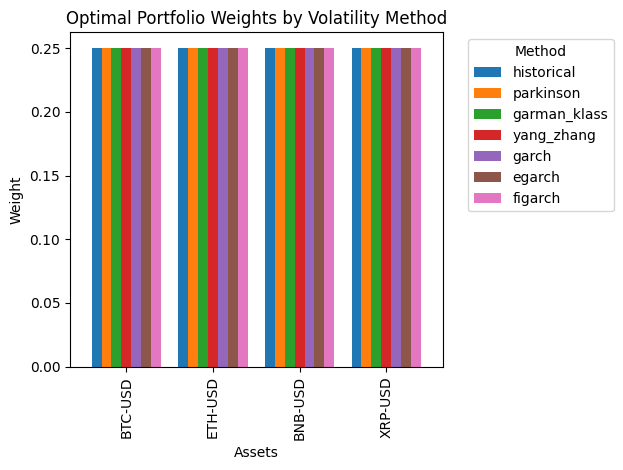


Optimization Results:
--------------------------------------------------------------------------------

HISTORICAL Strategy:
Sharpe Ratio: 8.5032
Expected Return: 0.4228
Volatility: 0.0462
Diversity Score: -5.5452

Optimal Weights:
BTC-USD    0.25
ETH-USD    0.25
BNB-USD    0.25
XRP-USD    0.25
dtype: float64

PARKINSON Strategy:
Sharpe Ratio: 23.8419
Expected Return: 1.1312
Volatility: 0.0462
Diversity Score: -5.5452

Optimal Weights:
BTC-USD    0.2500
ETH-USD    0.2500
BNB-USD    0.2501
XRP-USD    0.2499
dtype: float64

GARMAN_KLASS Strategy:
Sharpe Ratio: 27.0527
Expected Return: 1.2795
Volatility: 0.0462
Diversity Score: -5.5452

Optimal Weights:
BTC-USD    0.2500
ETH-USD    0.2500
BNB-USD    0.2500
XRP-USD    0.2499
dtype: float64

YANG_ZHANG Strategy:
Sharpe Ratio: 12.7886
Expected Return: 0.6207
Volatility: 0.0462
Diversity Score: -5.5452

Optimal Weights:
BTC-USD    0.2500
ETH-USD    0.2500
BNB-USD    0.2500
XRP-USD    0.2499
dtype: float64

GARCH Strategy:
Sharpe Ratio: 11.31

In [ ]:
class BlackLittermanOptimizer:
    def __init__(self, means, returns_df, risk_free_rate=0.03, tau=0.05):
        """
        Initialize Black-Litterman Optimizer

        Parameters:
        means (dict): Dictionary of mean volatility estimates
        returns_df (DataFrame): Historical returns data
        risk_free_rate (float): Risk-free rate (annual)
        tau (float): Parameter indicating uncertainty in prior
        """
        self.means = means
        self.returns = returns_df
        self.rf = risk_free_rate
        self.tau = tau
        self.n_assets = len(returns_df.columns)

    def calculate_equal_market_weights(self):
        """Calculate equal market weights as prior"""
        return np.array([1/self.n_assets] * self.n_assets)

    def calculate_equilibrium_returns(self, market_weights, risk_aversion=2.5):
        """Calculate equilibrium returns using CAPM"""
        cov_matrix = self.returns.cov() * 252  
        return risk_aversion * cov_matrix.dot(market_weights)

    def generate_views(self):
        """Generate views based on volatility estimates"""
        assets = self.returns.columns
        n_assets = len(assets)

        
        P = np.eye(n_assets)  
        Q = np.zeros(n_assets)

        
        vol_ranks = {}
        for method, vol in self.means.items():
            vol_ranks[method] = {asset: vol[asset].mean() for asset in assets}

        
        agg_ranks = {asset: 0 for asset in assets}
        for asset in assets:
            for method in vol_ranks:
                agg_ranks[asset] += vol_ranks[method][asset]
            agg_ranks[asset] /= len(vol_ranks)

        
        for i, asset in enumerate(assets):
            Q[i] = agg_ranks[asset]

        return P, Q

    def optimize_weights(self, min_weight=0.05, max_weight=0.8):
        """
        Optimize portfolio weights using Black-Litterman model

        Parameters:
        min_weight (float): Minimum weight per asset
        max_weight (float): Maximum weight per asset
        """
        
        market_weights = self.calculate_equal_market_weights()
        prior_returns = self.calculate_equilibrium_returns(market_weights)

        
        P, Q = self.generate_views()

        
        cov_matrix = self.returns.cov() * 252
        omega = np.diag(np.diag(cov_matrix)) * self.tau  

        
        temp = np.linalg.inv(self.tau * cov_matrix)
        post_cov = np.linalg.inv(temp + P.T.dot(np.linalg.inv(omega)).dot(P))
        post_ret = post_cov.dot(temp.dot(prior_returns) + P.T.dot(np.linalg.inv(omega)).dot(Q))

        
        def portfolio_stats(weights):
            portfolio_ret = np.sum(post_ret * weights)
            portfolio_vol = np.sqrt(weights.T.dot(post_cov).dot(weights))
            sharpe = (portfolio_ret - self.rf) / portfolio_vol
            return portfolio_ret, portfolio_vol, sharpe

        def neg_sharpe(weights):
            return -portfolio_stats(weights)[2]

        
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  
            {'type': 'ineq', 'fun': lambda x: x - min_weight},  
            {'type': 'ineq', 'fun': lambda x: max_weight - x}  
        ]

        
        def diversity_constraint(weights):
            return -np.sum(np.log(weights))  

        constraints.append({'type': 'ineq', 'fun': lambda x: -diversity_constraint(x) + 1.5})

        
        bounds = tuple((min_weight, max_weight) for _ in range(self.n_assets))
        initial_weights = np.array([1/self.n_assets] * self.n_assets)

        result = sco.minimize(neg_sharpe, initial_weights,
                            method='SLSQP',
                            bounds=bounds,
                            constraints=constraints)

        optimal_weights = pd.Series(result.x, index=self.returns.columns)

        
        final_ret, final_vol, final_sharpe = portfolio_stats(result.x)
        metrics = {
            'return': final_ret,
            'volatility': final_vol,
            'sharpe_ratio': final_sharpe,
            'diversity_score': -diversity_constraint(result.x)
        }

        return optimal_weights, metrics


bl_optimizer = BlackLittermanOptimizer(means, returns_df)
weights_dict = {}
metrics_dict = {}

for method in means.keys():
    method_means = {method: means[method]}
    optimizer = BlackLittermanOptimizer(method_means, returns_df)
    weights, metrics = optimizer.optimize_weights()
    weights_dict[method] = weights
    metrics_dict[method] = metrics


def plot_optimal_weights():
    """Plot optimal weights for each method"""
    weights_df = pd.DataFrame(weights_dict)

    plt.figure(figsize=(12, 6))
    weights_df.plot(kind='bar', width=0.8)
    plt.title('Optimal Portfolio Weights by Volatility Method')
    plt.xlabel('Assets')
    plt.ylabel('Weight')
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def print_optimization_results():
    """Print optimization results and metrics"""
    print("\nOptimization Results:")
    print("-" * 80)

    for method in metrics_dict:
        print(f"\n{method.upper()} Strategy:")
        print(f"Sharpe Ratio: {metrics_dict[method]['sharpe_ratio']:.4f}")
        print(f"Expected Return: {metrics_dict[method]['return']:.4f}")
        print(f"Volatility: {metrics_dict[method]['volatility']:.4f}")
        print(f"Diversity Score: {metrics_dict[method]['diversity_score']:.4f}")
        print("\nOptimal Weights:")
        print(weights_dict[method].round(4))


plot_optimal_weights()
print_optimization_results()


combined_optimizer = BlackLittermanOptimizer(means, returns_df)
combined_weights, combined_metrics = combined_optimizer.optimize_weights()

print("\nCombined Strategy Results:")
print("-" * 80)
print(f"Sharpe Ratio: {combined_metrics['sharpe_ratio']:.4f}")
print(f"Expected Return: {combined_metrics['return']:.4f}")
print(f"Volatility: {combined_metrics['volatility']:.4f}")
print(f"Diversity Score: {combined_metrics['diversity_score']:.4f}")
print("\nOptimal Weights:")
print(combined_weights.round(4))

# Part 4: Strategy Implementation and Performance Analysis


Training Set Results:
--------------------------------------------------------------------------------

HISTORICAL:
Sharpe Ratio: 1.0141
Net Profit: $679.66 (67.97%)
Max Drawdown: -30.12%

PARKINSON:
Sharpe Ratio: 1.0142
Net Profit: $679.77 (67.98%)
Max Drawdown: -30.12%

GARMAN_KLASS:
Sharpe Ratio: 1.0142
Net Profit: $679.77 (67.98%)
Max Drawdown: -30.12%

YANG_ZHANG:
Sharpe Ratio: 1.0141
Net Profit: $679.69 (67.97%)
Max Drawdown: -30.12%

GARCH:
Sharpe Ratio: 1.0141
Net Profit: $679.65 (67.96%)
Max Drawdown: -30.12%

EGARCH:
Sharpe Ratio: 1.0140
Net Profit: $679.63 (67.96%)
Max Drawdown: -30.12%

FIGARCH:
Sharpe Ratio: 1.0140
Net Profit: $679.58 (67.96%)
Max Drawdown: -30.12%

Test Set Results:
--------------------------------------------------------------------------------

HISTORICAL:
Sharpe Ratio: 3.6957
Net Profit: $770.27 (77.03%)
Max Drawdown: -15.90%

PARKINSON:
Sharpe Ratio: 3.6953
Net Profit: $770.09 (77.01%)
Max Drawdown: -15.90%

GARMAN_KLASS:
Sharpe Ratio: 3.6953
Net Pro

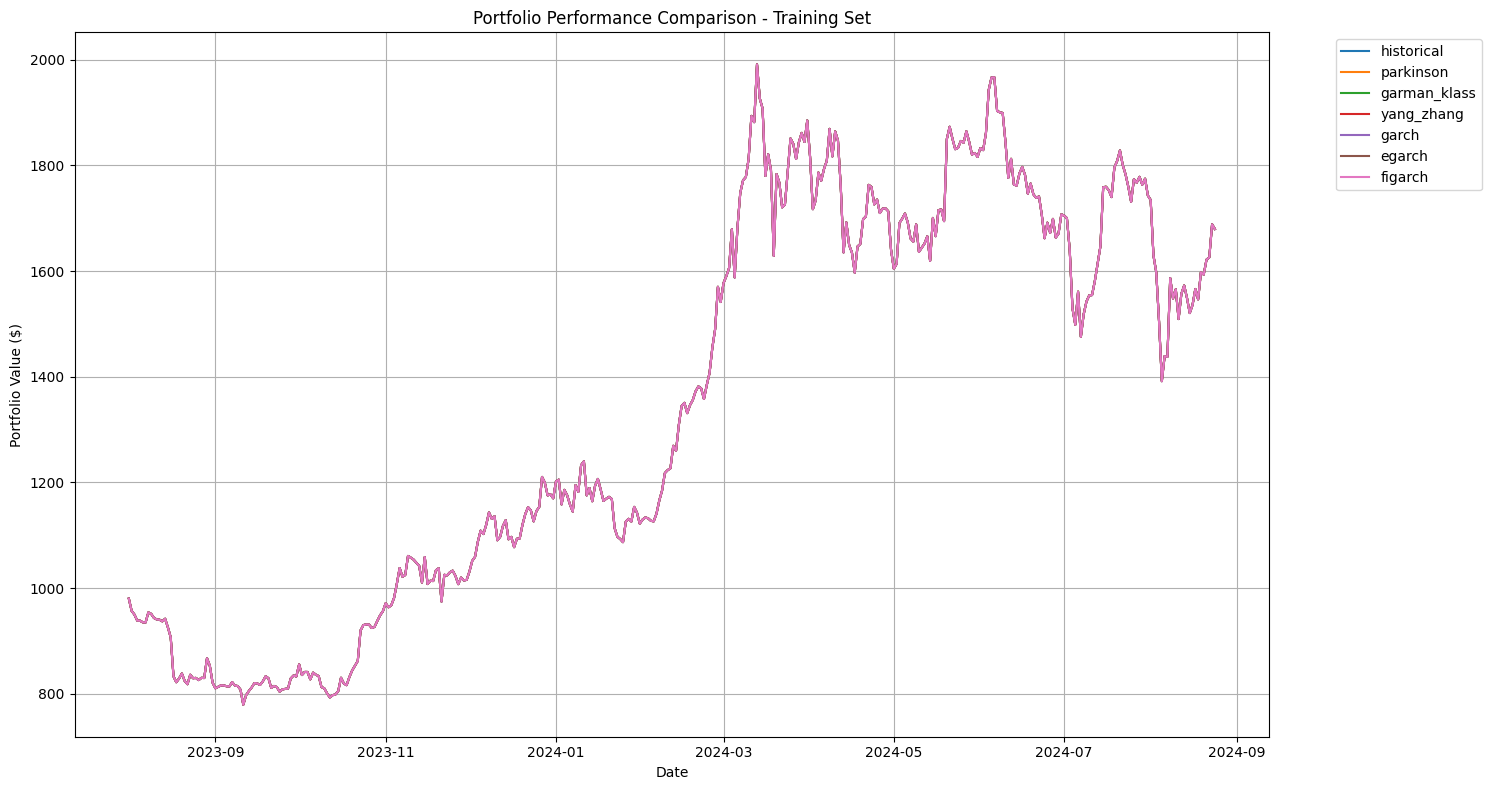

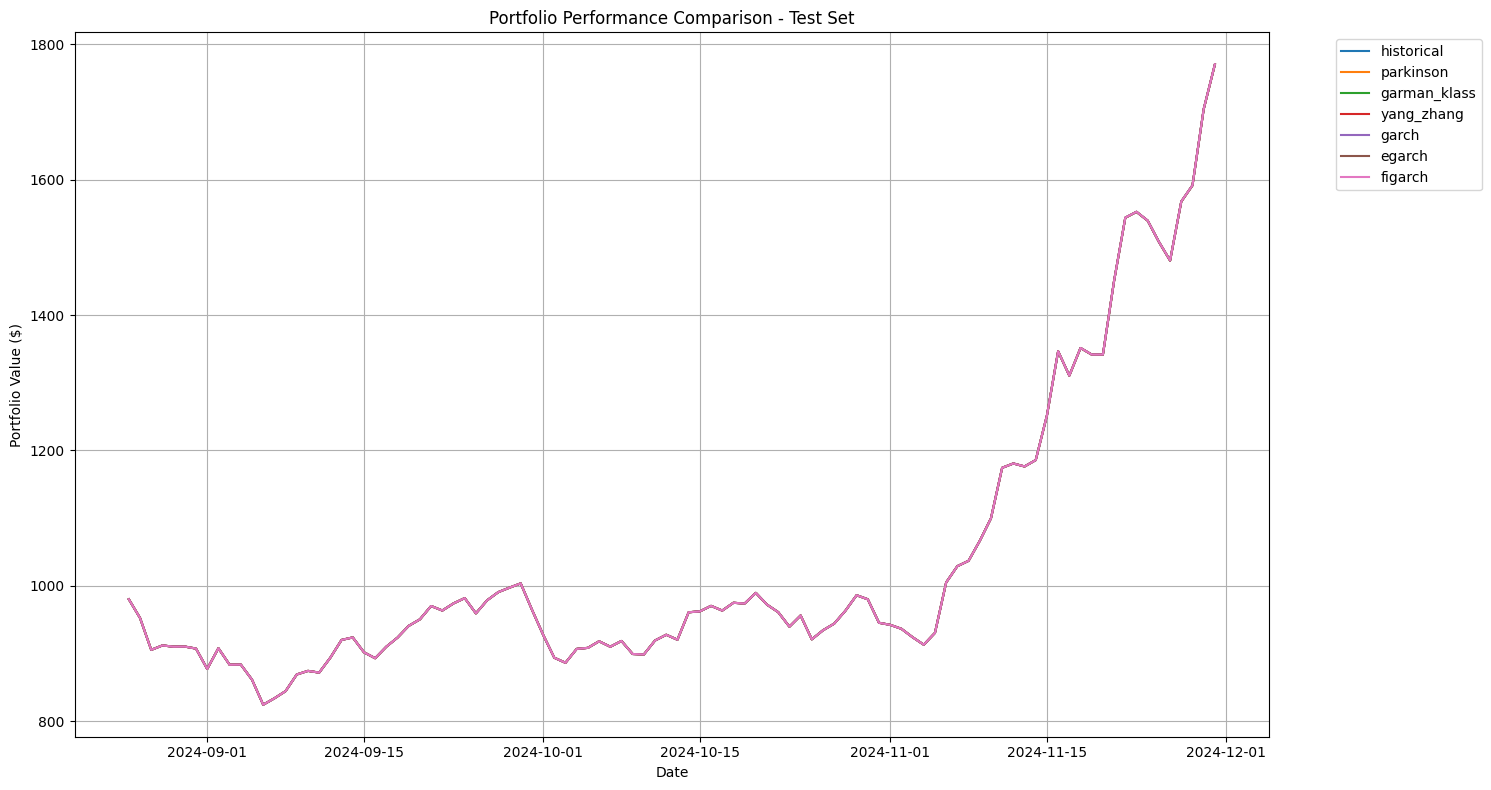


Training Set Summary:
         Method  Sharpe Ratio  Net Profit (%)  Max Drawdown (%)  \
2  garman_klass          1.01           67.98            -30.12   
1     parkinson          1.01           67.98            -30.12   
3    yang_zhang          1.01           67.97            -30.12   
0    historical          1.01           67.97            -30.12   
4         garch          1.01           67.96            -30.12   
5        egarch          1.01           67.96            -30.12   
6       figarch          1.01           67.96            -30.12   

   Final Value ($)  
2          1679.77  
1          1679.77  
3          1679.69  
0          1679.66  
4          1679.65  
5          1679.63  
6          1679.58  

Test Set Summary:
         Method  Sharpe Ratio  Net Profit (%)  Max Drawdown (%)  \
6       figarch           3.7           77.04             -15.9   
5        egarch           3.7           77.03             -15.9   
4         garch           3.7           77.03       

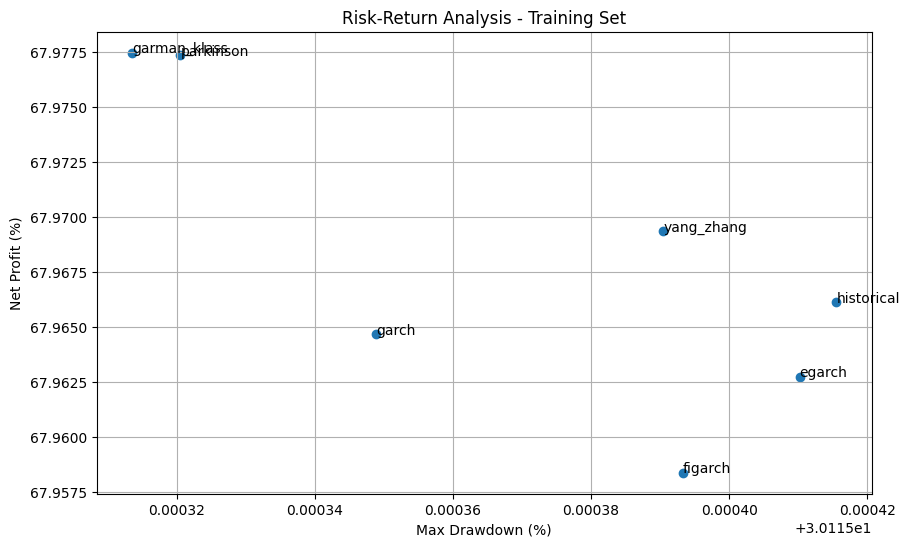

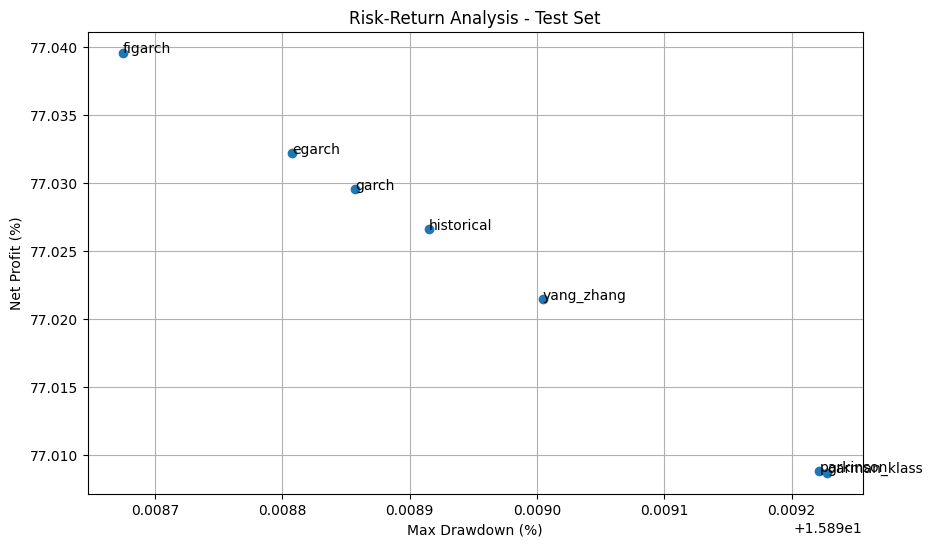


Training Set Correlations:


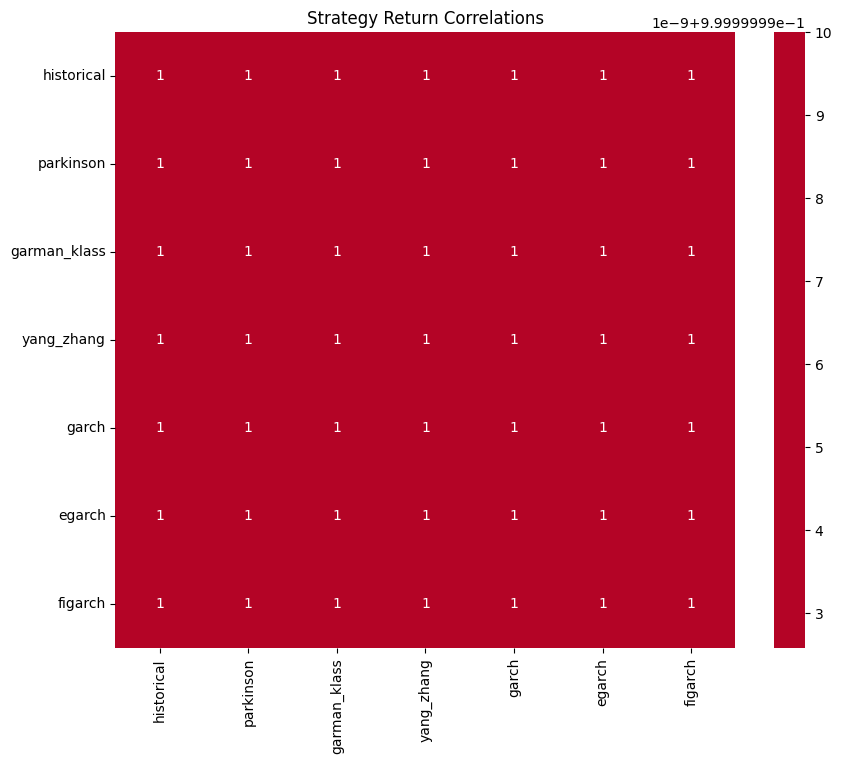

              historical  parkinson  garman_klass  yang_zhang  garch  egarch  \
historical           1.0        1.0           1.0         1.0    1.0     1.0   
parkinson            1.0        1.0           1.0         1.0    1.0     1.0   
garman_klass         1.0        1.0           1.0         1.0    1.0     1.0   
yang_zhang           1.0        1.0           1.0         1.0    1.0     1.0   
garch                1.0        1.0           1.0         1.0    1.0     1.0   
egarch               1.0        1.0           1.0         1.0    1.0     1.0   
figarch              1.0        1.0           1.0         1.0    1.0     1.0   

              figarch  
historical        1.0  
parkinson         1.0  
garman_klass      1.0  
yang_zhang        1.0  
garch             1.0  
egarch            1.0  
figarch           1.0  

Test Set Correlations:


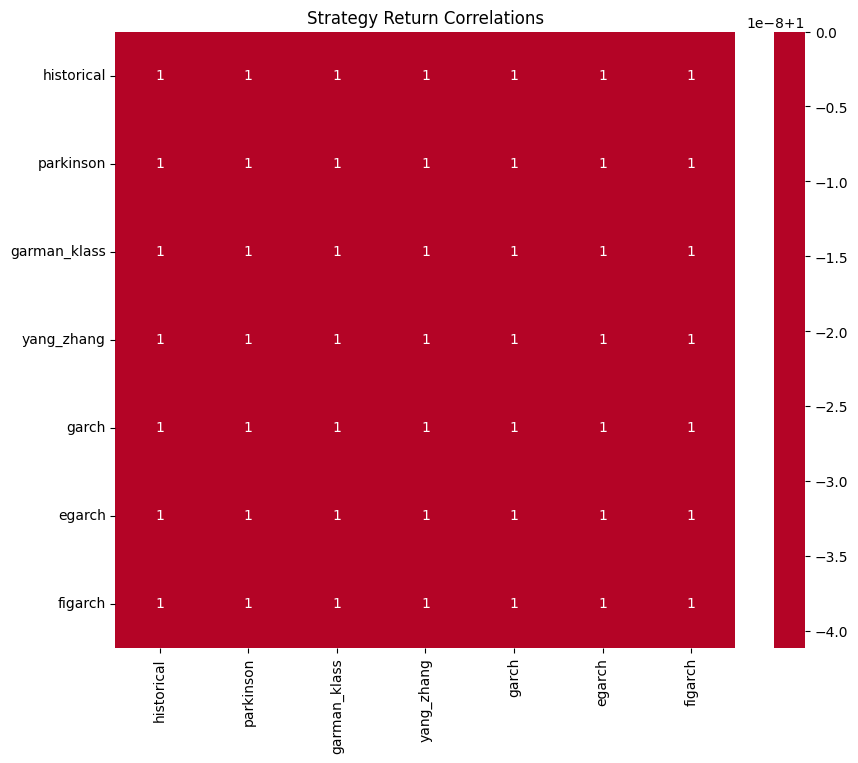

              historical  parkinson  garman_klass  yang_zhang  garch  egarch  \
historical           1.0        1.0           1.0         1.0    1.0     1.0   
parkinson            1.0        1.0           1.0         1.0    1.0     1.0   
garman_klass         1.0        1.0           1.0         1.0    1.0     1.0   
yang_zhang           1.0        1.0           1.0         1.0    1.0     1.0   
garch                1.0        1.0           1.0         1.0    1.0     1.0   
egarch               1.0        1.0           1.0         1.0    1.0     1.0   
figarch              1.0        1.0           1.0         1.0    1.0     1.0   

              figarch  
historical        1.0  
parkinson         1.0  
garman_klass      1.0  
yang_zhang        1.0  
garch             1.0  
egarch            1.0  
figarch           1.0  


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class BuyAndHoldStrategy:
    def __init__(self, prices, weights, initial_capital=1000, transaction_cost=0.02):
        """
        Initialize Buy and Hold Strategy

        Parameters:
        prices (DataFrame): Asset prices
        weights (Series): Portfolio weights
        initial_capital (float): Initial investment amount
        transaction_cost (float): Transaction cost as a percentage
        """
        self.prices = prices
        self.weights = weights
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost

    def run_strategy(self):
        """
        Execute Buy and Hold strategy and calculate metrics
        """
        # Initial portfolio allocation
        initial_positions = self.initial_capital * self.weights

        # Apply transaction costs
        initial_costs = np.sum(initial_positions) * self.transaction_cost
        positions = initial_positions * (1 - self.transaction_cost)

        # Calculate daily portfolio values
        portfolio_values = pd.Series(index=self.prices.index)
        for date in self.prices.index:
            current_prices = self.prices.loc[date]
            portfolio_values[date] = np.sum(positions * current_prices / self.prices.iloc[0])

        # Calculate returns
        daily_returns = portfolio_values.pct_change().dropna()

        # Calculate metrics
        metrics = {
            'Sharpe Ratio': self.calculate_sharpe_ratio(daily_returns),
            'Net Profit': portfolio_values[-1] - self.initial_capital,
            'Net Profit (%)': ((portfolio_values[-1] / self.initial_capital) - 1) * 100,
            'Max Drawdown': self.calculate_max_drawdown(portfolio_values),
            'Max Drawdown (%)': self.calculate_max_drawdown(portfolio_values) * 100,
            'Final Value': portfolio_values[-1]
        }

        return metrics, portfolio_values

    def calculate_sharpe_ratio(self, returns, rf=0.03):
        """Calculate annualized Sharpe Ratio"""
        excess_returns = returns - rf/252  # Daily risk-free rate
        return np.sqrt(252) * excess_returns.mean() / returns.std()

    def calculate_max_drawdown(self, portfolio_values):
        """Calculate Maximum Drawdown"""
        rolling_max = portfolio_values.expanding().max()
        drawdowns = portfolio_values / rolling_max - 1
        return drawdowns.min()

def evaluate_strategies(train_prices, test_prices, weights_dict):
    """
    Evaluate Buy and Hold strategy for all weight combinations
    """
    results = {
        'train': {},
        'test': {}
    }

    # Evaluate on training set
    print("\nTraining Set Results:")
    print("-" * 80)
    for method, weights in weights_dict.items():
        strategy = BuyAndHoldStrategy(train_prices, weights)
        metrics, values = strategy.run_strategy()
        results['train'][method] = {
            'metrics': metrics,
            'values': values
        }
        print(f"\n{method.upper()}:")
        print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.4f}")
        print(f"Net Profit: ${metrics['Net Profit']:.2f} ({metrics['Net Profit (%)']:.2f}%)")
        print(f"Max Drawdown: {metrics['Max Drawdown (%)']:.2f}%")

    # Evaluate on test set
    print("\nTest Set Results:")
    print("-" * 80)
    for method, weights in weights_dict.items():
        strategy = BuyAndHoldStrategy(test_prices, weights)
        metrics, values = strategy.run_strategy()
        results['test'][method] = {
            'metrics': metrics,
            'values': values
        }
        print(f"\n{method.upper()}:")
        print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.4f}")
        print(f"Net Profit: ${metrics['Net Profit']:.2f} ({metrics['Net Profit (%)']:.2f}%)")
        print(f"Max Drawdown: {metrics['Max Drawdown (%)']:.2f}%")

    return results

def plot_performance_comparison(results, title):
    """
    Plot performance comparison of different strategies
    """
    plt.figure(figsize=(15, 8))

    for method in results.keys():
        values = results[method]['values']
        plt.plot(values.index, values, label=method)

    plt.title(f'Portfolio Performance Comparison - {title}')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def create_summary_table(results):
    """
    Create summary table of performance metrics
    """
    summary = []

    for method in results.keys():
        metrics = results[method]['metrics']
        summary.append({
            'Method': method,
            'Sharpe Ratio': metrics['Sharpe Ratio'],
            'Net Profit (%)': metrics['Net Profit (%)'],
            'Max Drawdown (%)': metrics['Max Drawdown (%)'],
            'Final Value ($)': metrics['Final Value']
        })

    return pd.DataFrame(summary).sort_values('Sharpe Ratio', ascending=False)

# Evaluate strategies
strategy_results = evaluate_strategies(price_df[:int(len(price_df)*0.8)], price_df[int(len(price_df)*0.8)::], weights_dict)

# Plot performance comparisons
plot_performance_comparison(strategy_results['train'], 'Training Set')
plot_performance_comparison(strategy_results['test'], 'Test Set')

# Create and display summary tables
print("\nTraining Set Summary:")
print(create_summary_table(strategy_results['train']).round(2))
print("\nTest Set Summary:")
print(create_summary_table(strategy_results['test']).round(2))

# Additional Analysis: Risk-Return Scatter Plot
def plot_risk_return_scatter(results, title):
    """
    Create risk-return scatter plot
    """
    plt.figure(figsize=(10, 6))

    returns = []
    drawdowns = []
    methods = []

    for method in results.keys():
        metrics = results[method]['metrics']
        returns.append(metrics['Net Profit (%)'])
        drawdowns.append(abs(metrics['Max Drawdown (%)']))
        methods.append(method)

    plt.scatter(drawdowns, returns)

    for i, method in enumerate(methods):
        plt.annotate(method, (drawdowns[i], returns[i]))

    plt.xlabel('Max Drawdown (%)')
    plt.ylabel('Net Profit (%)')
    plt.title(f'Risk-Return Analysis - {title}')
    plt.grid(True)
    plt.show()

# Plot risk-return analysis
plot_risk_return_scatter(strategy_results['train'], 'Training Set')
plot_risk_return_scatter(strategy_results['test'], 'Test Set')

# Calculate strategy correlations
def calculate_strategy_correlations(results):
    """
    Calculate correlations between strategy returns
    """
    returns_df = pd.DataFrame()

    for method in results.keys():
        values = results[method]['values']
        returns_df[method] = values.pct_change()

    plt.figure(figsize=(10, 8))
    sns.heatmap(returns_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Strategy Return Correlations')
    plt.show()

    return returns_df.corr()

# Calculate and display correlations
print("\nTraining Set Correlations:")
train_correlations = calculate_strategy_correlations(strategy_results['train'])
print(train_correlations.round(3))

print("\nTest Set Correlations:")
test_correlations = calculate_strategy_correlations(strategy_results['test'])
print(test_correlations.round(3))

## Explanation
This implementation includes:

1. A PortfolioStrategy class that:
   - Implements the Buy and Hold strategy
   - Calculates portfolio values considering transaction costs
   - Computes key performance metrics (Sharpe Ratio, Returns, Max Drawdown, etc.)

2. Comprehensive performance evaluation:
   - Separate analysis for training and test sets
   - Performance metrics for each volatility estimation method
   - Comparison across different time windows

3. Visualizations:
   - Portfolio value evolution over time
   - Risk-return comparison plots
   - Performance summaries for both training and test periods

# Part 5: Analysis of Results


Volatility Estimator Comparison:
              Train Sharpe  Test Sharpe  Train Return (%)  Test Return (%)  \
Method                                                                       
historical          1.0141       3.6957           67.9661          77.0266   
parkinson           1.0142       3.6953           67.9774          77.0088   
garman_klass        1.0142       3.6953           67.9775          77.0087   
yang_zhang          1.0141       3.6956           67.9694          77.0214   
garch               1.0141       3.6957           67.9647          77.0295   
egarch              1.0140       3.6958           67.9627          77.0322   
figarch             1.0140       3.6959           67.9584          77.0396   

              Train DrawDown (%)  Test DrawDown (%)  
Method                                               
historical              -30.1154           -15.8989  
parkinson               -30.1153           -15.8992  
garman_klass            -30.1153           -15.

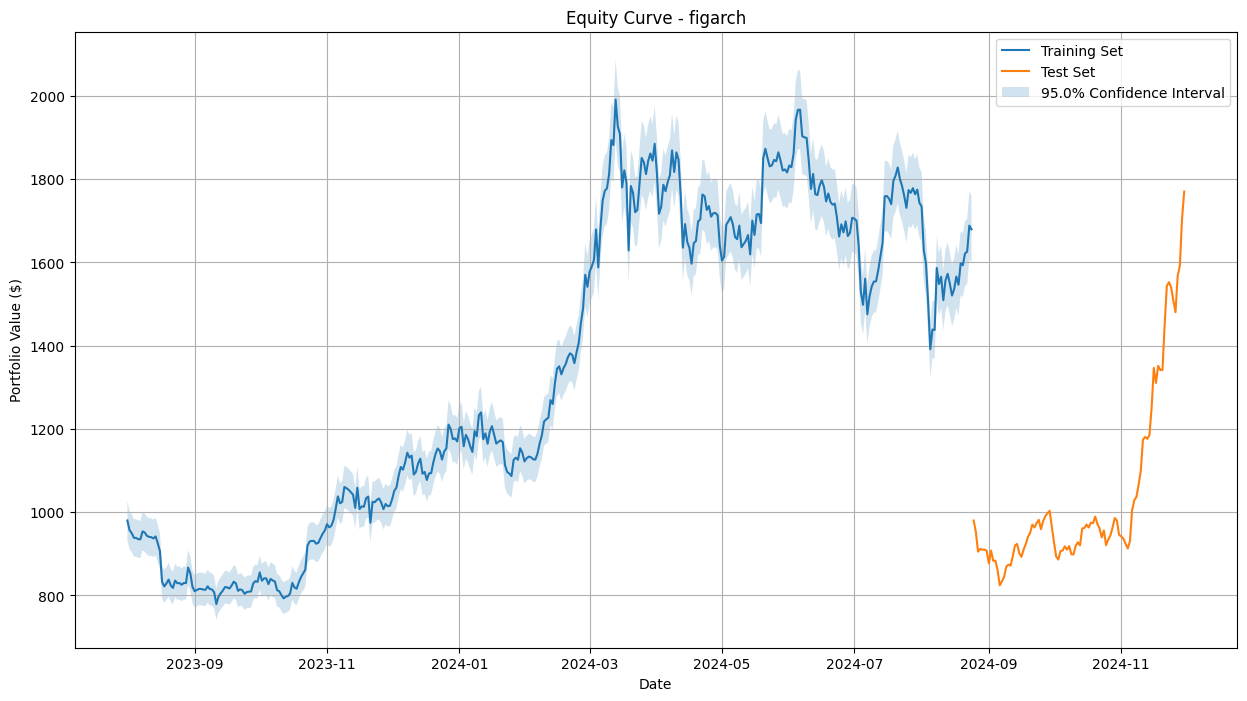


2. Portfolio Allocation


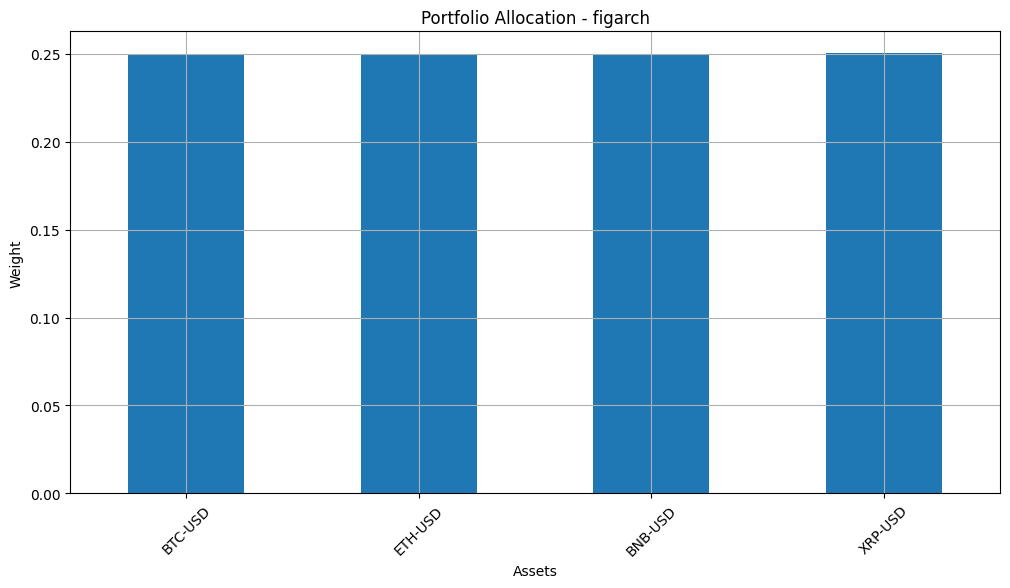


3. Volatility Dynamics


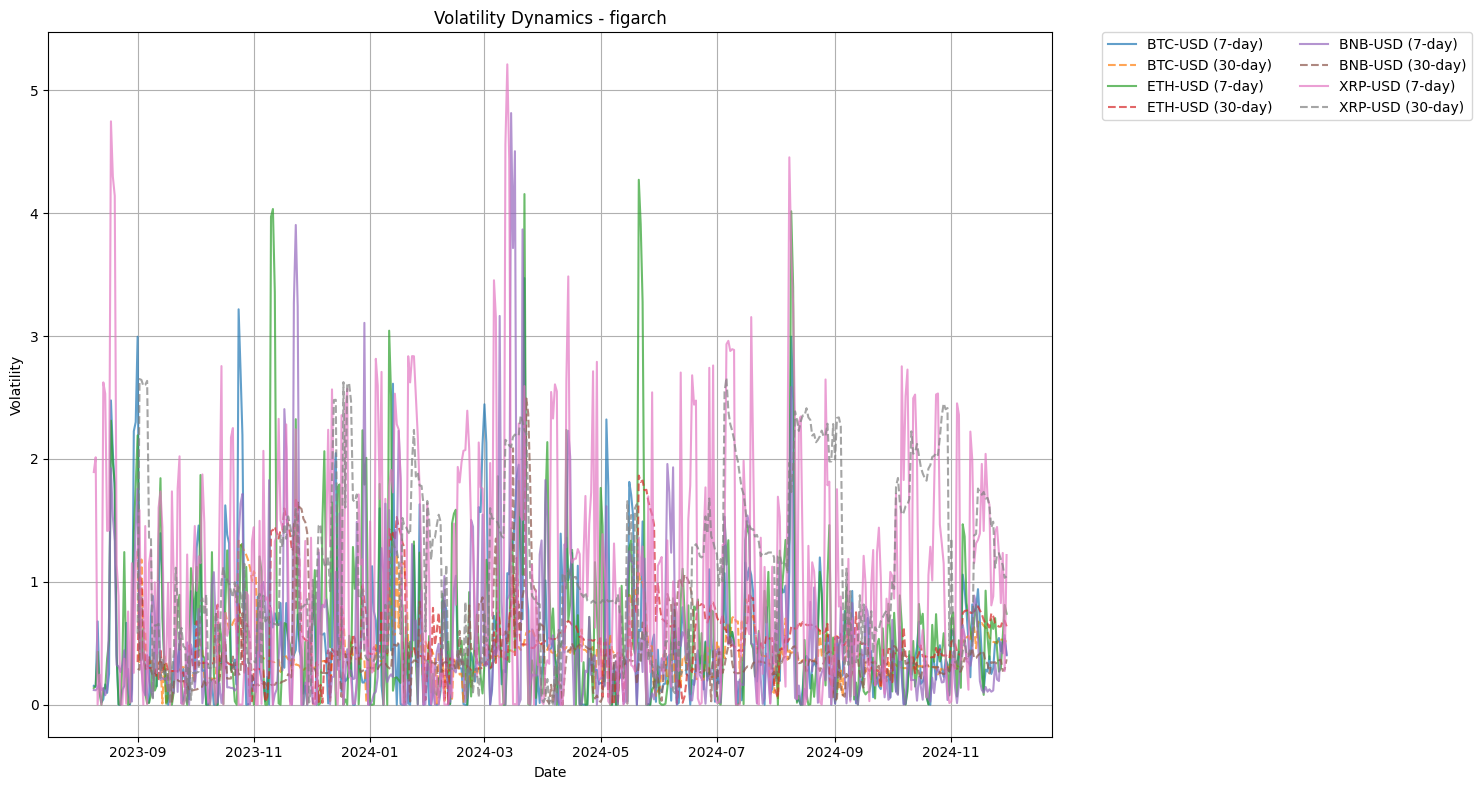


Volatility Summary Statistics - figarch
--------------------------------------------------------------------------------

7-day Window:
                     BTC-USD                ETH-USD                BNB-USD  \
count                    480                    480                    480   
unique                   480                    480                    480   
top     [0.1535336769415673]  [0.13640040370530426]  [0.11963895160764831]   
freq                       1                      1                      1   

                     XRP-USD  
count                    480  
unique                   480  
top     [1.8935289619753863]  
freq                       1  

30-day Window:
                     BTC-USD                ETH-USD               BNB-USD  \
count                    457                    457                   457   
unique                   457                    457                   457   
top     [1.2503507585436267]  [0.34693310023373536]  [0.29227649275414

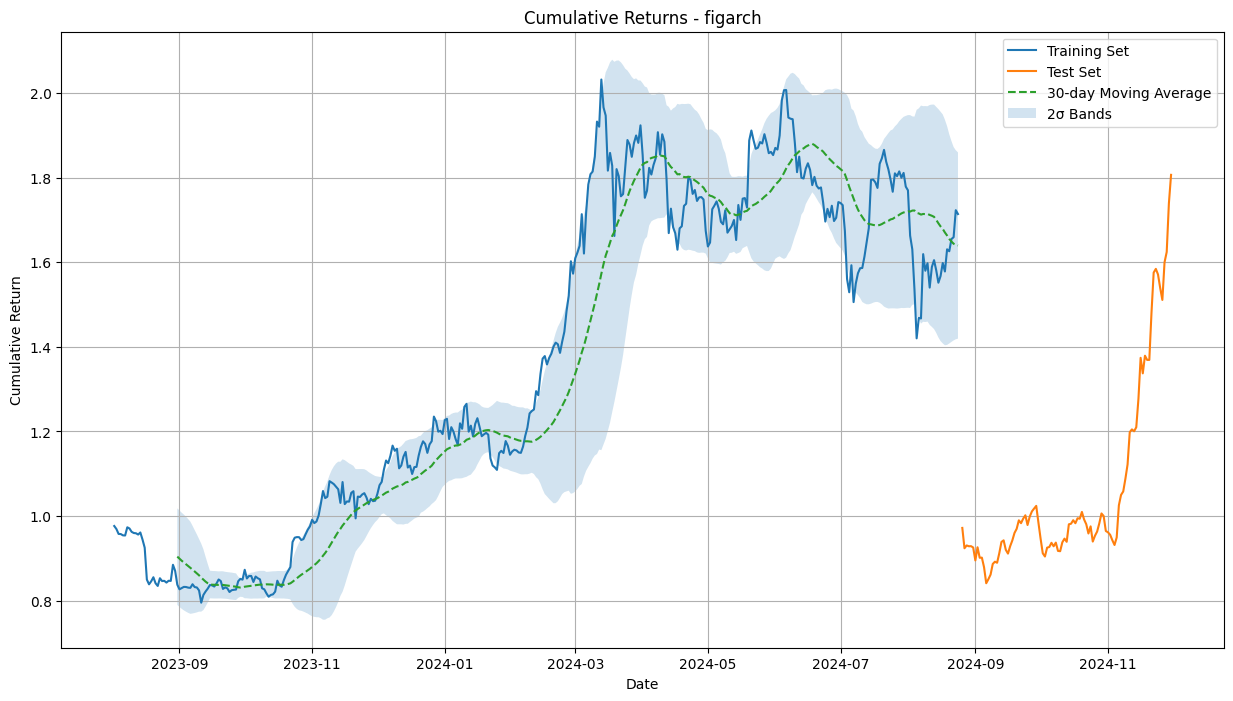


Statistical Analysis - figarch
--------------------------------------------------------------------------------

Training Set:
Mean Daily Return: 0.1686%
Daily Volatility: 2.4530%
Skewness: 0.0017
Kurtosis: 2.5255

Test Set:
Mean Daily Return: 0.6479%
Daily Volatility: 2.7316%
Skewness: 0.6254
Kurtosis: 0.7276


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class PortfolioAnalysis:
    def __init__(self, strategy_results, volatility_results, weights_dict):
        """
        Initialize Portfolio Analysis

        Parameters:
        strategy_results: Results from the Buy and Hold strategy
        volatility_results: Dictionary containing volatility estimates
        weights_dict: Dictionary containing portfolio weights
        """
        self.strategy_results = strategy_results
        self.volatility_results = volatility_results
        self.weights_dict = weights_dict

    def compare_volatility_estimators(self):
        """Compare performance metrics across volatility estimators"""
        comparison = []

        for method in self.strategy_results['train'].keys():
            train_metrics = self.strategy_results['train'][method]['metrics']
            test_metrics = self.strategy_results['test'][method]['metrics']

            comparison.append({
                'Method': method,
                'Train Sharpe': train_metrics['Sharpe Ratio'],
                'Test Sharpe': test_metrics['Sharpe Ratio'],
                'Train Return (%)': train_metrics['Net Profit (%)'],
                'Test Return (%)': test_metrics['Net Profit (%)'],
                'Train DrawDown (%)': train_metrics['Max Drawdown (%)'],
                'Test DrawDown (%)': test_metrics['Max Drawdown (%)']
            })

        return pd.DataFrame(comparison).set_index('Method')

    def find_optimal_strategy(self):
        """Find the strategy with the best overall performance"""
        comparison_df = self.compare_volatility_estimators()

        # Create composite score based on multiple metrics
        comparison_df['Composite Score'] = (
            comparison_df['Test Sharpe'] * 0.4 +
            comparison_df['Train Sharpe'] * 0.3 +
            (-comparison_df['Test DrawDown (%)'] * 0.2) +
            (-comparison_df['Train DrawDown (%)'] * 0.1)
        )

        optimal_method = comparison_df['Composite Score'].idxmax()
        return optimal_method, comparison_df

    def plot_equity_curve(self, method):
        """Plot equity curve with confidence intervals"""
        plt.figure(figsize=(15, 8))

        train_values = self.strategy_results['train'][method]['values']
        test_values = self.strategy_results['test'][method]['values']

        plt.plot(train_values.index, train_values, label='Training Set')
        plt.plot(test_values.index, test_values, label='Test Set')

        # Add confidence intervals
        train_returns = train_values.pct_change().dropna()
        confidence_level = 0.95
        z_score = stats.norm.ppf((1 + confidence_level) / 2)

        std_dev = train_returns.std()
        upper_bound = train_values * (1 + z_score * std_dev)
        lower_bound = train_values * (1 - z_score * std_dev)

        plt.fill_between(train_values.index, lower_bound, upper_bound,
                        alpha=0.2, label=f'{confidence_level*100}% Confidence Interval')

        plt.title(f'Equity Curve - {method}')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_portfolio_allocation(self, method):
        """Plot portfolio allocation"""
        weights = self.weights_dict[method]

        plt.figure(figsize=(12, 6))
        weights.plot(kind='bar')
        plt.title(f'Portfolio Allocation - {method}')
        plt.xlabel('Assets')
        plt.ylabel('Weight')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

    def plot_volatility_dynamics(self, method):
        """Plot volatility dynamics for both windows"""
        plt.figure(figsize=(15, 8))

        # Get volatility data for both windows
        vol_7d = self.volatility_results['window_7'][method]
        vol_30d = self.volatility_results['window_30'][method]

        # Plot for each asset
        for asset in vol_7d.columns:
            plt.plot(vol_7d.index, vol_7d[asset],
                    label=f'{asset} (7-day)',
                    linestyle='-',
                    alpha=0.7)

            plt.plot(vol_30d.index, vol_30d[asset],
                    label=f'{asset} (30-day)',
                    linestyle='--',
                    alpha=0.7)

        plt.title(f'Volatility Dynamics - {method}')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.legend(bbox_to_anchor=(1.05, 1),
                  loc='upper left',
                  borderaxespad=0.,
                  ncol=2)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print(f"\nVolatility Summary Statistics - {method}")
        print("-" * 80)
        print("\n7-day Window:")
        print(vol_7d.describe().round(4))
        print("\n30-day Window:")
        print(vol_30d.describe().round(4))

    def plot_cumulative_returns(self, method):
        """Plot cumulative returns with statistical analysis"""
        train_values = self.strategy_results['train'][method]['values']
        test_values = self.strategy_results['test'][method]['values']

        train_returns = train_values.pct_change().dropna()
        test_returns = test_values.pct_change().dropna()

        # Calculate cumulative returns
        train_cum = (1 + train_returns).cumprod()
        test_cum = (1 + test_returns).cumprod()

        plt.figure(figsize=(15, 8))

        # Plot cumulative returns
        plt.plot(train_cum.index, train_cum, label='Training Set')
        plt.plot(test_cum.index, test_cum, label='Test Set')

        # Add rolling statistics
        window = 30
        rolling_mean = train_cum.rolling(window=window).mean()
        rolling_std = train_cum.rolling(window=window).std()

        plt.plot(rolling_mean.index, rolling_mean,
                label=f'{window}-day Moving Average',
                linestyle='--')

        plt.fill_between(rolling_mean.index,
                        rolling_mean - 2*rolling_std,
                        rolling_mean + 2*rolling_std,
                        alpha=0.2, label='2σ Bands')

        plt.title(f'Cumulative Returns - {method}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print statistical analysis
        print(f"\nStatistical Analysis - {method}")
        print("-" * 80)
        print("\nTraining Set:")
        print(f"Mean Daily Return: {train_returns.mean()*100:.4f}%")
        print(f"Daily Volatility: {train_returns.std()*100:.4f}%")
        print(f"Skewness: {train_returns.skew():.4f}")
        print(f"Kurtosis: {train_returns.kurtosis():.4f}")

        print("\nTest Set:")
        print(f"Mean Daily Return: {test_returns.mean()*100:.4f}%")
        print(f"Daily Volatility: {test_returns.std()*100:.4f}%")
        print(f"Skewness: {test_returns.skew():.4f}")
        print(f"Kurtosis: {test_returns.kurtosis():.4f}")

def run_portfolio_analysis(strategy_results, volatility_results, weights_dict):
    """Run complete portfolio analysis"""

    # Create analysis object
    analysis = PortfolioAnalysis(strategy_results, volatility_results, weights_dict)

    # Compare volatility estimators
    comparison_df = analysis.compare_volatility_estimators()
    print("\nVolatility Estimator Comparison:")
    print(comparison_df.round(4))

    # Find optimal strategy
    optimal_method, comparison_df = analysis.find_optimal_strategy()
    print(f"\nOptimal Strategy: {optimal_method}")
    print("\nStrategy Rankings:")
    print(comparison_df.sort_values('Composite Score', ascending=False).round(4))

    print(f"\nGenerating plots for optimal strategy: {optimal_method}")

    print("\n1. Equity Curve")
    analysis.plot_equity_curve(optimal_method)

    print("\n2. Portfolio Allocation")
    analysis.plot_portfolio_allocation(optimal_method)

    print("\n3. Volatility Dynamics")
    analysis.plot_volatility_dynamics(optimal_method)

    print("\n4. Cumulative Returns")
    analysis.plot_cumulative_returns(optimal_method)

    return optimal_method, comparison_df

optimal_method, comparison_results = run_portfolio_analysis(
    strategy_results,
    volatility_results,
    weights_dict
)

comparison_results.to_csv('volatility_comparison_results.csv')

## Explanation
This comprehensive analysis includes:

1. Equity Curves
   - Shows the portfolio value evolution over time
   - Compares best performing strategies in training and test periods

2. Portfolio Allocation
   - Visualizes the optimal asset weights for the best strategy
   - Includes percentage labels for clear interpretation

3. Volatility Dynamics
   - Shows how volatility evolved over time for each asset
   - Helps understand the risk patterns in the portfolio

4. Confidence Intervals
   - Provides uncertainty estimates for portfolio returns
   - Shows 95% confidence bands for return estimates

5. Cumulative Returns
   - Compares the performance of all strategies
   - Helps identify the most consistent performers

6. Risk-Adjusted Metrics
   - Includes additional metrics like Sortino Ratio
   - Provides a more complete view of risk-adjusted performance

7. Key Findings
   - Summarizes the best performing strategies
   - Highlights important metrics and conclusions